In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install scapy

In [2]:
train_df = pd.read_csv("Mar-29-2021.csv", index_col=0)
train_df.head()

Implementation    Mode  \
Run                                                              
0     ./server -d . -c /QUIC-Ivy/doc/examples/quic/...  server   
1     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
2     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
3     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   
4     ./server -c /QUIC-Ivy/doc/examples/quic/leaf_...  server   

                     TestName  Status                ErrorIEV  \
Run                                                             
0    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
1    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
2    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
3    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   
4    quic_server_test_stream0     NaN  ivy_return_code(1)+"")   

                                         OutputFile  NbPktSend  isPass  
Run                                                                     
0    /results/temp/355/quic_server_test_stream0.iev        0.0     0.0  
1    /results/temp/405/quic_server_test_stream0.iev        0.0     0.0  
2    /results/temp/406/quic_server_test_stream0.iev        0.0     0.0  
3    /results/temp/456/quic_server_test_stream0.iev        0.0     0.0  
4    /results/temp/457/quic_server_test_stream0.iev        0.0     0.0

In [3]:
server_name = train_df.Implementation.unique()
servers = []
for s in server_name:
    if "cargo run" in s:
        servers.append("quinn")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quinn")
    if "./http_server" in s:
        servers.append("lsquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "lsquic")
    if "./picoquicdemo" in s:
        servers.append("picoquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "picoquic")
    if "./server -d" in s:
        servers.append("quant")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quant")
    if "./server -c" in s:
        servers.append("quic-go")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quic-go")
    if "python3" in s:
        servers.append("aioquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "aioquic")
    if "echo" in s:
        servers.append("mvfst")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "mvfst")
        
print(servers)
train_df["isPass"] = train_df["isPass"].replace(0.0, 0)
train_df["isPass"] = train_df["isPass"].replace(1.0, 1)
train_df.head()

['quant', 'quic-go', 'aioquic', 'quinn', 'mvfst', 'picoquic']


Implementation    Mode                  TestName  Status  \
Run                                                            
0            quant  server  quic_server_test_stream0     NaN   
1          quic-go  server  quic_server_test_stream0     NaN   
2          quic-go  server  quic_server_test_stream0     NaN   
3          quic-go  server  quic_server_test_stream0     NaN   
4          quic-go  server  quic_server_test_stream0     NaN   

                   ErrorIEV                                      OutputFile  \
Run                                                                           
0    ivy_return_code(1)+"")  /results/temp/355/quic_server_test_stream0.iev   
1    ivy_return_code(1)+"")  /results/temp/405/quic_server_test_stream0.iev   
2    ivy_return_code(1)+"")  /results/temp/406/quic_server_test_stream0.iev   
3    ivy_return_code(1)+"")  /results/temp/456/quic_server_test_stream0.iev   
4    ivy_return_code(1)+"")  /results/temp/457/quic_server_test_stream0.iev   

     NbPktSend  isPass  
Run                     
0          0.0     0.0  
1          0.0     0.0  
2          0.0     0.0  
3          0.0     0.0  
4          0.0     0.0

In [126]:
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = "server-result-2" + row["OutputFile"][8:]
        f = open(resultFile, "r")
        content = f.read()
        if "frame.connection_close:" in content and not "quic_server_test_connection_close" in resultFile:
            start_index = content.find("frame.connection_close:")
            end_index = content.find(",",start_index)
            train_df.loc[i, "ErrorIEV"] = content[start_index:end_index+1].replace(",","") + "}"
        elif "Run out of cid" in content:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif "ivy_return_code(139)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 139"
        elif "ivy_return_code(134)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 134"
        elif content.count("tls_recv_event") > 10:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed"
        elif "timeout" in content and "undecryptable_packet_event" in content:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed" 
        elif "ivy_return_code(1)+value(" in row["ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif 'ivy_return_code(1)+"")' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
        elif 'assumption_failed(""' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            c = c.replace("\n","")
            c = c.replace("    ","")
            train_df.loc[i, "ErrorIEV"] = c
        elif 'ivy_return_code(1)+"")' in content:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
    else:
        train_df.loc[i, "ErrorIEV"] = "No Error"

for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        train_df.loc[i, "ErrorIEV"]  = train_df.loc[i, "ErrorIEV"].replace("\n","").replace("    ","")
train_df.head()

Implementation    Mode                 TestName  Status  \
Run                                                           
0            quant  server  quic_server_test_stream     NaN   
1          quic-go  server  quic_server_test_stream     NaN   
2          quic-go  server  quic_server_test_stream     NaN   
3          quic-go  server  quic_server_test_stream     NaN   
4          quic-go  server  quic_server_test_stream     NaN   

                    ErrorIEV                                      OutputFile  \
Run                                                                            
0    Handshake not completed  /results/temp/355/quic_server_test_stream0.iev   
1    Handshake not completed  /results/temp/405/quic_server_test_stream0.iev   
2    Handshake not completed  /results/temp/406/quic_server_test_stream0.iev   
3    Handshake not completed  /results/temp/456/quic_server_test_stream0.iev   
4    Handshake not completed  /results/temp/457/quic_server_test_stream0.iev   

     NbPktSend  isPass  ErrorsCode  
Run                                 
0         23.0     0.0           0  
1         16.0     0.0           0  
2          8.0     0.0           0  
3         14.0     0.0           0  
4         14.0     0.0           0

In [114]:
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        if 'timeout+> client' in row["ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"]  = "Handshake not completed" 

In [95]:
train_df.head(100)

Implementation    Mode                           TestName  Status  \
Run                                                                     
0            quant  server            quic_server_test_stream     NaN   
1          quic-go  server            quic_server_test_stream     NaN   
2          quic-go  server            quic_server_test_stream     NaN   
3          quic-go  server            quic_server_test_stream     NaN   
4          quic-go  server            quic_server_test_stream     NaN   
5          aioquic  server            quic_server_test_stream     NaN   
6          aioquic  server            quic_server_test_stream     NaN   
7          aioquic  server            quic_server_test_stream     NaN   
8          aioquic  server            quic_server_test_stream     NaN   
9            quinn  server            quic_server_test_unkown     NaN   
10           quinn  server            quic_server_test_unkown     NaN   
11           quinn  server            quic_server_test_unkown     NaN   
12           quinn  server            quic_server_test_unkown     NaN   
13           mvfst  server            quic_server_test_unkown     NaN   
14           mvfst  server            quic_server_test_unkown     NaN   
15           mvfst  server            quic_server_test_unkown     NaN   
16        picoquic  server            quic_server_test_unkown     NaN   
17        picoquic  server            quic_server_test_unkown     NaN   
18           quant  server            quic_server_test_unkown     NaN   
19           quant  server            quic_server_test_unkown     NaN   
20           quant  server            quic_server_test_unkown     NaN   
21         quic-go  server            quic_server_test_unkown     NaN   
22         quic-go  server            quic_server_test_unkown     NaN   
23         quic-go  server            quic_server_test_unkown     NaN   
24         quic-go  server            quic_server_test_unkown     NaN   
25         aioquic  server            quic_server_test_unkown     NaN   
26         aioquic  server            quic_server_test_unkown     NaN   
27         aioquic  server            quic_server_test_unkown     NaN   
28         aioquic  server            quic_server_test_unkown     NaN   
29           quinn  server  quic_server_test_tp_limit_newcoid     NaN   
..             ...     ...                                ...     ...   
70         quic-go  server               quic_server_test_max     NaN   
71         quic-go  server               quic_server_test_max     NaN   
72         quic-go  server               quic_server_test_max     NaN   
73         aioquic  server               quic_server_test_max     NaN   
74         aioquic  server               quic_server_test_max     NaN   
75         aioquic  server               quic_server_test_max     NaN   
76         aioquic  server               quic_server_test_max     NaN   
77           quinn  server       quic_server_test_token_error     NaN   
78           quinn  server       quic_server_test_token_error     NaN   
79           quinn  server       quic_server_test_token_error     NaN   
80           quinn  server       quic_server_test_token_error     NaN   
81           mvfst  server       quic_server_test_token_error     NaN   
82           mvfst  server       quic_server_test_token_error     NaN   
83           mvfst  server       quic_server_test_token_error     NaN   
84           mvfst  server       quic_server_test_token_error     NaN   
85        picoquic  server       quic_server_test_token_error     NaN   
86        picoquic  server       quic_server_test_token_error     NaN   
87        picoquic  server       quic_server_test_token_error     NaN   
88        picoquic  server       quic_server_test_token_error     NaN   
89           quant  server       quic_server_test_token_error     NaN   
90           quant  server       quic_server_test_token_error     NaN   
91           quant  server       quic_server_test_token_error 

In [112]:
train_df.TestName.unique()
train_df["ErrorIEV"].unique().tolist()

['Handshake not completed',
 'frame.connection_close:{err_code:0xa}',
 'No Error',
 'require is_frame_encoding_error;"',
 'Segmentation Fault 139',
 'frame.connection_close:{err_code:0x7}',
 'Segmentation Fault 134',
 'server_return_code(1)+timeout',
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"',
 'frame.connection_close:{err_code:0xa2d8}',
 'frame.connection_close:{err_code:0xfe9b}',
 'frame.connection_close:{err_code:0xa0ff}',
 'frame.connection_close:{err_code:0x3cd5}',
 'frame.connection_close:{err_code:0xde5c}',
 'frame.connection_close:{err_code:0x545d}',
 'frame.connection_close:{err_code:0xfca6}',
 'frame.connection_close:{err_code:0xf664}',
 'frame.connection_close:{err_code:0x6c5d}',
 'frame.connection_close:{err_code:0xde70}',
 'frame.connection_close:{err_code:0x4ee1}',
 'frame.connection_close:{err_code:0x7053}',
 'frame.connection_close:{err_code:0xf2ff}',
 'frame.connection_close:{err_code:0xf824}',
 'frame.connection_close:{err_code:0x1e16}',

In [132]:
from scapy.all import *
import threading
import multiprocessing

# splitting dataframe by row index 
total_rows = train_df.shape[0]
print(total_rows)
cnt  = 10 #multiprocessing.cpu_count()
size = total_rows / cnt
size = int(size)
print(size)
list_of_dfs = [train_df.loc[i:i+size-1,:] for i in range(0, len(train_df),size)]
print(len(list_of_dfs))
print()
j = 0


def process_pkt(df):
    for index, row in df.iterrows():
        outfile = row["OutputFile"]
        if "iev" in row["OutputFile"] :
            i =  row["OutputFile"][outfile.find("/",13)+1:outfile.find("/",14)] 
            if isinstance(row["TestName"],str) and not row["TestName"] == np.nan :
                resultFile = "temp/" + str(i) + "_quic_server_" + str(row["TestName"])  + ".pcap"
                packets = rdpcap(resultFile)
                ln = len(packets)
                df.loc[index, "NbPktSend"] = ln
    
        
for index in range(cnt):
    process_pkt(list_of_dfs[index])
    toPrint = (j/size) * 10
    print(str(toPrint) + "% Processed")
    train_df.to_csv(path_or_buf="server2_processed.csv",index=False)
    j += size
    

train_df.head()

10800
1080
10

0.0% Processed
10.0% Processed
20.0% Processed
30.0% Processed
40.0% Processed
50.0% Processed
60.0% Processed
70.0% Processed
80.0% Processed
90.0% Processed


Implementation    Mode                 TestName  Status  \
Run                                                           
0            quant  server  quic_server_test_stream     NaN   
1          quic-go  server  quic_server_test_stream     NaN   
2          quic-go  server  quic_server_test_stream     NaN   
3          quic-go  server  quic_server_test_stream     NaN   
4          quic-go  server  quic_server_test_stream     NaN   

                    ErrorIEV                                      OutputFile  \
Run                                                                            
0    Handshake not completed  /results/temp/355/quic_server_test_stream0.iev   
1    Handshake not completed  /results/temp/405/quic_server_test_stream0.iev   
2    Handshake not completed  /results/temp/406/quic_server_test_stream0.iev   
3    Handshake not completed  /results/temp/456/quic_server_test_stream0.iev   
4    Handshake not completed  /results/temp/457/quic_server_test_stream0.iev   

     NbPktSend  isPass  ErrorsCode  
Run                                 
0         23.0     0.0           0  
1         16.0     0.0           0  
2          8.0     0.0           0  
3         14.0     0.0           0  
4         14.0     0.0           0

In [ ]:
train_df["ErrorOUT"] = ""
train_df["ErrorERR"] = ""
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = "server_result" + row["OutputFile"][8:]
        resultFile = resultFile.replace(".iev",".out")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorOUT"] = content[start_index:end_index+1]
        resultFile = resultFile.replace(".iev",".err")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorERR"] = content[start_index:end_index+1]
                        
train_df.head()

In [ ]:
train_df.to_csv(path_or_buf="server2_processed.csv",index=False)

In [39]:
for i, row in train_df.iterrows():
    if isinstance(row["TestName"], str):
        train_df.loc[i, "TestName"] = row["TestName"].replace("0","")
    else:
        index = row["OutputFile"].find("q")
        train_df.loc[i, "TestName"] = row["OutputFile"][index:].replace("0","").replace(".iev","")
                        
train_df.head(100)

Implementation    Mode                           TestName  Status  \
Run                                                                     
0            quant  server            quic_server_test_stream     NaN   
1          quic-go  server            quic_server_test_stream     NaN   
2          quic-go  server            quic_server_test_stream     NaN   
3          quic-go  server            quic_server_test_stream     NaN   
4          quic-go  server            quic_server_test_stream     NaN   
5          aioquic  server            quic_server_test_stream     NaN   
6          aioquic  server            quic_server_test_stream     NaN   
7          aioquic  server            quic_server_test_stream     NaN   
8          aioquic  server            quic_server_test_stream     NaN   
9            quinn  server            quic_server_test_unkown     NaN   
10           quinn  server            quic_server_test_unkown     NaN   
11           quinn  server            quic_server_test_unkown     NaN   
12           quinn  server            quic_server_test_unkown     NaN   
13           mvfst  server            quic_server_test_unkown     NaN   
14           mvfst  server            quic_server_test_unkown     NaN   
15           mvfst  server            quic_server_test_unkown     NaN   
16        picoquic  server            quic_server_test_unkown     NaN   
17        picoquic  server            quic_server_test_unkown     NaN   
18           quant  server            quic_server_test_unkown     NaN   
19           quant  server            quic_server_test_unkown     NaN   
20           quant  server            quic_server_test_unkown     NaN   
21         quic-go  server            quic_server_test_unkown     NaN   
22         quic-go  server            quic_server_test_unkown     NaN   
23         quic-go  server            quic_server_test_unkown     NaN   
24         quic-go  server            quic_server_test_unkown     NaN   
25         aioquic  server            quic_server_test_unkown     NaN   
26         aioquic  server            quic_server_test_unkown     NaN   
27         aioquic  server            quic_server_test_unkown     NaN   
28         aioquic  server            quic_server_test_unkown     NaN   
29           quinn  server  quic_server_test_tp_limit_newcoid     NaN   
..             ...     ...                                ...     ...   
70         quic-go  server               quic_server_test_max     NaN   
71         quic-go  server               quic_server_test_max     NaN   
72         quic-go  server               quic_server_test_max     NaN   
73         aioquic  server               quic_server_test_max     NaN   
74         aioquic  server               quic_server_test_max     NaN   
75         aioquic  server               quic_server_test_max     NaN   
76         aioquic  server               quic_server_test_max     NaN   
77           quinn  server       quic_server_test_token_error     NaN   
78           quinn  server       quic_server_test_token_error     NaN   
79           quinn  server       quic_server_test_token_error     NaN   
80           quinn  server       quic_server_test_token_error     NaN   
81           mvfst  server       quic_server_test_token_error     NaN   
82           mvfst  server       quic_server_test_token_error     NaN   
83           mvfst  server       quic_server_test_token_error     NaN   
84           mvfst  server       quic_server_test_token_error     NaN   
85        picoquic  server       quic_server_test_token_error     NaN   
86        picoquic  server       quic_server_test_token_error     NaN   
87        picoquic  server       quic_server_test_token_error     NaN   
88        picoquic  server       quic_server_test_token_error     NaN   
89           quant  server       quic_server_test_token_error     NaN   
90           quant  server       quic_server_test_token_error     NaN   
91           quant  server       quic_server_test_token_error 

In [145]:
train_df.Implementation.unique()


array(['quant', 'quic-go', 'aioquic', 'quinn', 'mvfst', 'picoquic'],
      dtype=object)

Text(0, 0.5, 'Count')

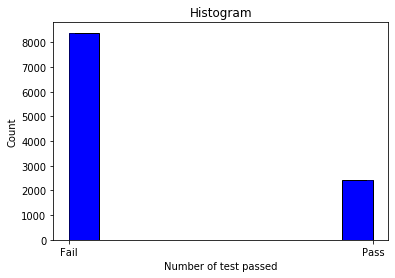

In [16]:
# matplotlib histogram

x = ["Pass","Fail"]

cnt = train_df['isPass'].value_counts()

plt.hist(train_df['isPass'], color = ['blue'], edgecolor = 'black')

# seaborn histogram
sns.distplot(train_df['isPass'], hist=True, kde=False, 
             color = ['blue'])

plt.xticks(np.arange(0, 2, 1))
positions = (0, 1)
labels = ("Fail", "Pass")
plt.xticks(positions, labels)
# Add labels
plt.title('Histogram')
plt.xlabel('Number of test passed')
plt.ylabel('Count')

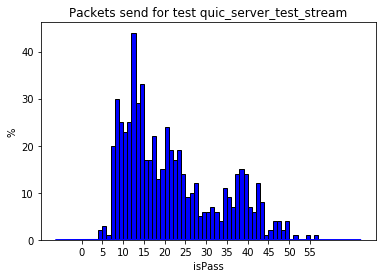

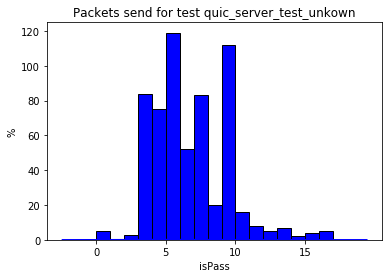

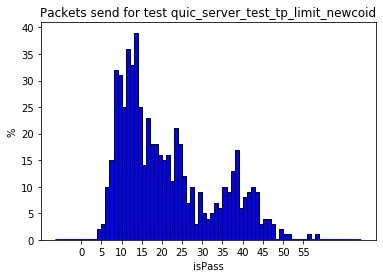

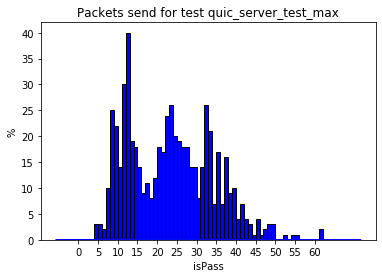

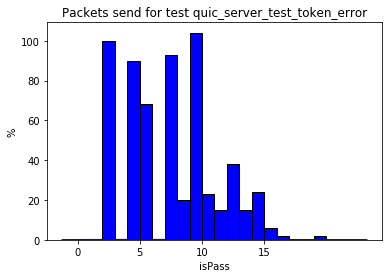

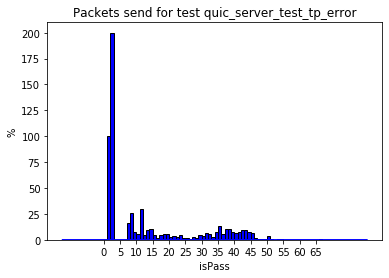

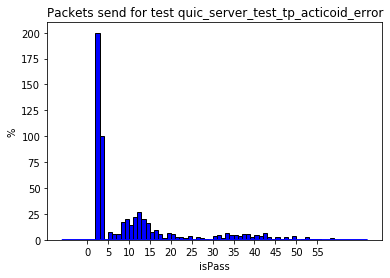

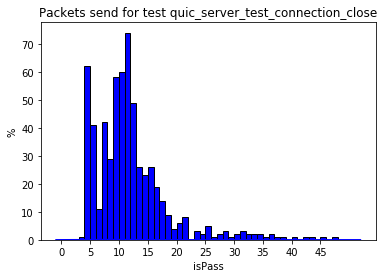

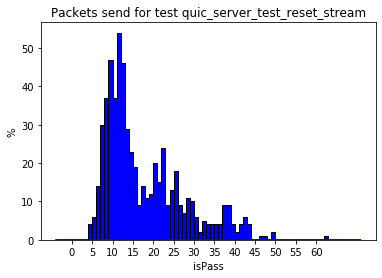

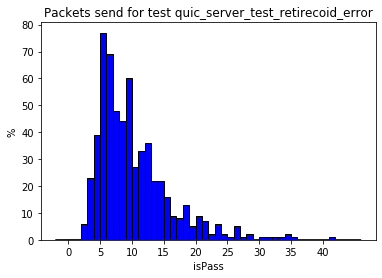

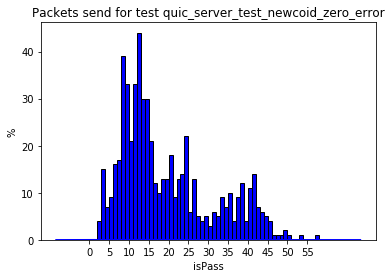

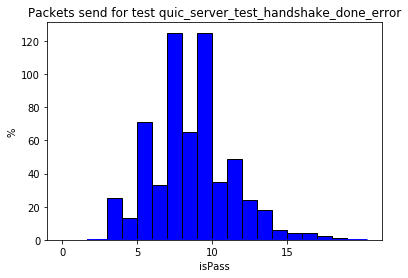

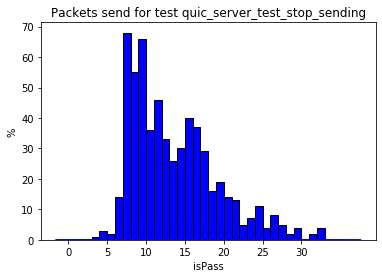

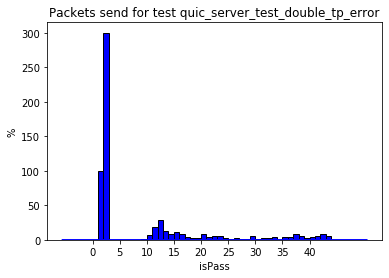

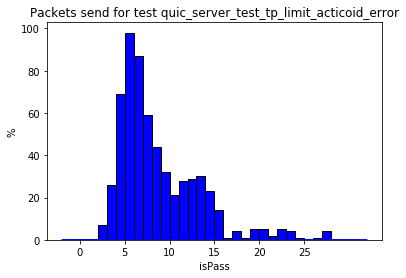

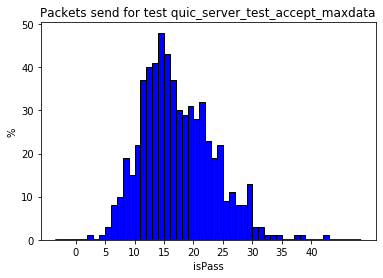

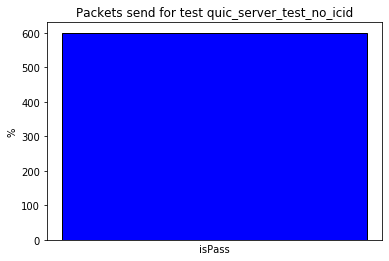

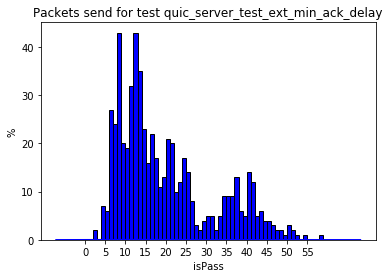

In [166]:
# Failure per test

train_df.TestName.unique()
tests = ['quic_server_test_stream', 'quic_server_test_unkown',
       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
       'quic_server_test_token_error', 'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream',
       'quic_server_test_retirecoid_error',
       'quic_server_test_newcoid_zero_error',
       'quic_server_test_handshake_done_error',
       'quic_server_test_stop_sending',
       'quic_server_test_double_tp_error',
       'quic_server_test_tp_limit_acticoid_error',
       'quic_server_test_accept_maxdata', 'quic_server_test_no_icid',
       'quic_server_test_ext_min_ack_delay']

#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    #subdf = subdf.loc[subdf['Implementation'] != "quinn"]
    max_value = subdf["NbPktSend"].max() 
    
    plt.hist(subdf['NbPktSend'], color = 'blue', edgecolor = 'black',
             range = [0,max_value],bins=max(int(max_value),1))

    # seaborn histogram
    sns.distplot(subdf['NbPktSend'], hist=False,
                 kde=True, color = 'blue')
    # Add labels
    plt.xticks(np.arange(0, int(max_value),5))
    # positions = (0, 1)
    # labels = ("Fail", "Pass")
    # plt.xticks(positions, labels)
    plt.title("Packets send for test " + t)
    plt.xlabel('isPass')
    plt.ylabel('%')
    filename = 'plot/' + "packets_" + t + "_for_" + s + '.png'
    plt.savefig(filename)
    plt.show()

In [ ]:
for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.distplot(subdf['isPass'], hist=True, kde=False, 
                 color = 'blue',bins=[0, 1])
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()

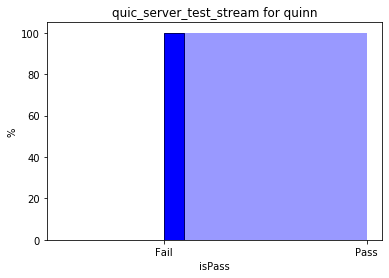

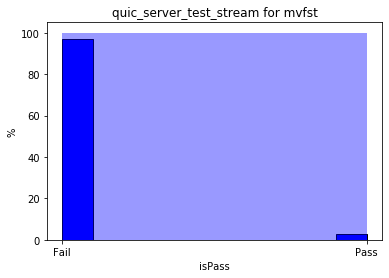

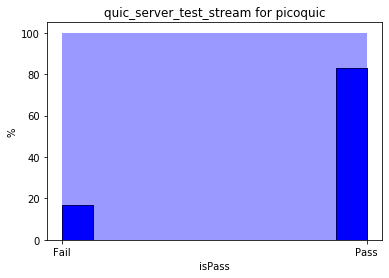

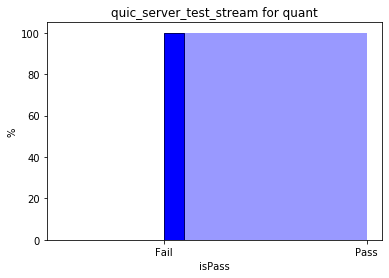

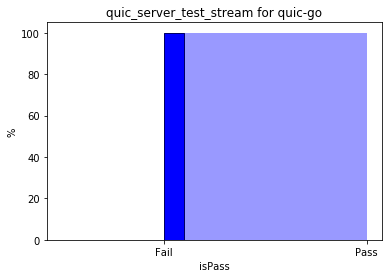

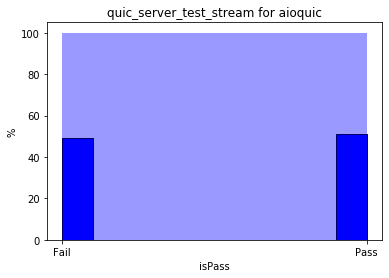

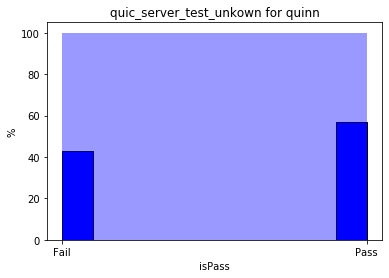

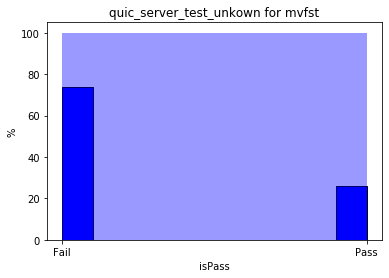

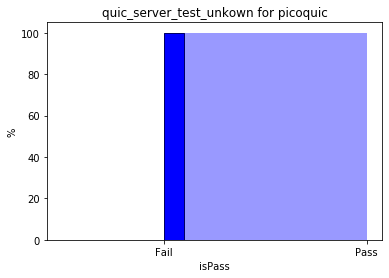

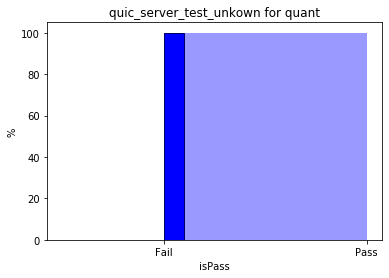

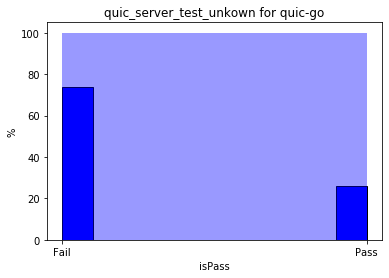

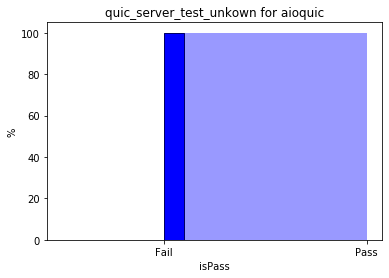

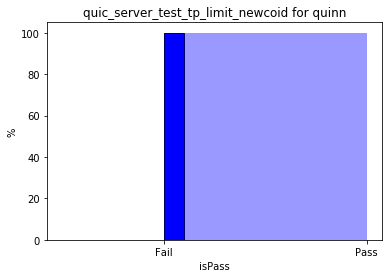

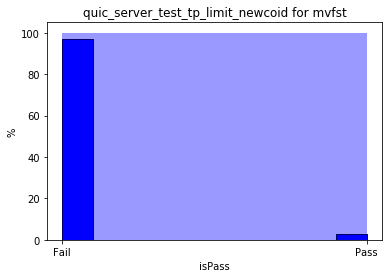

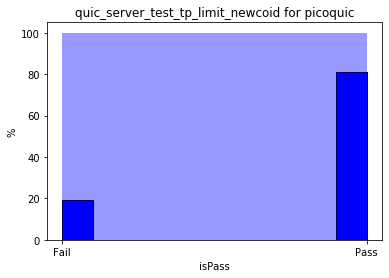

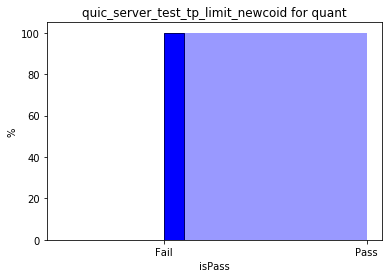

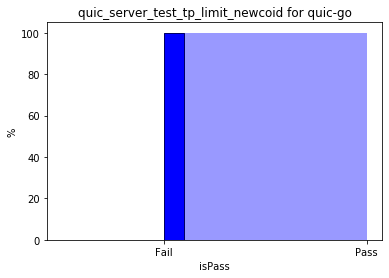

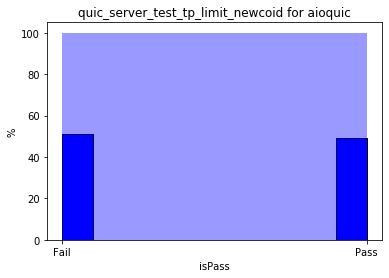

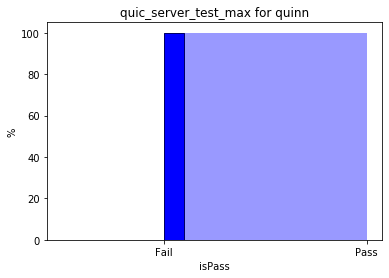

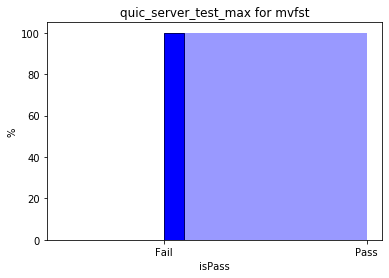

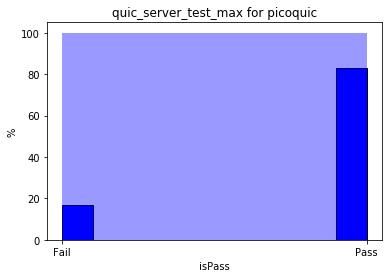

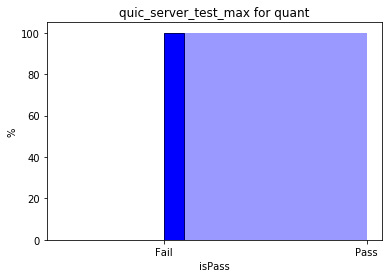

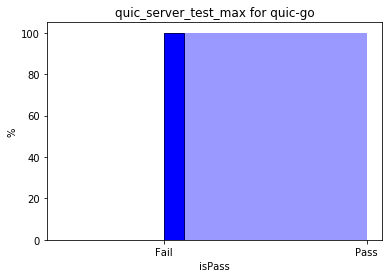

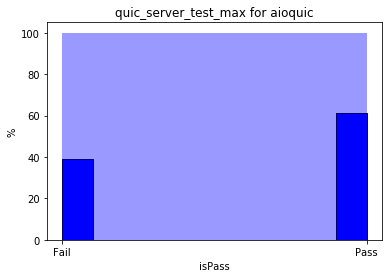

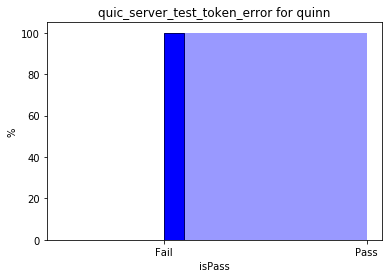

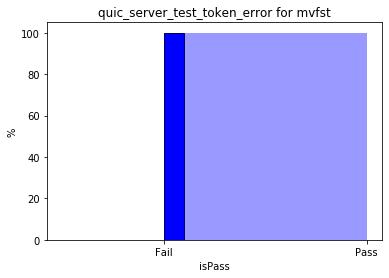

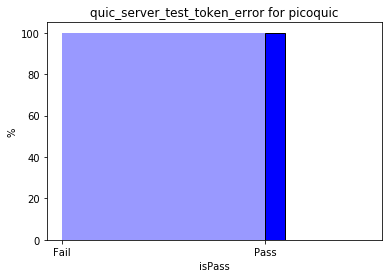

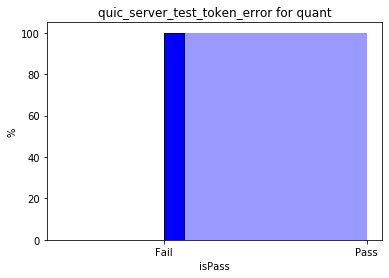

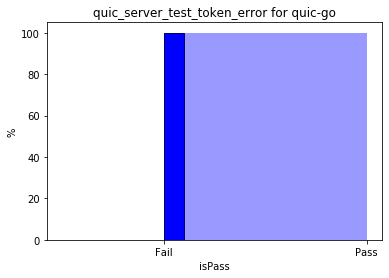

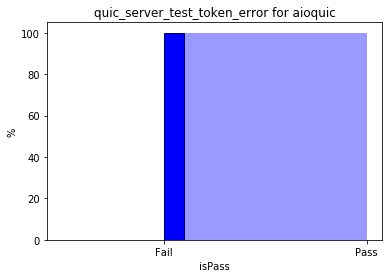

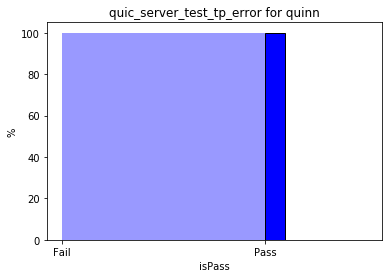

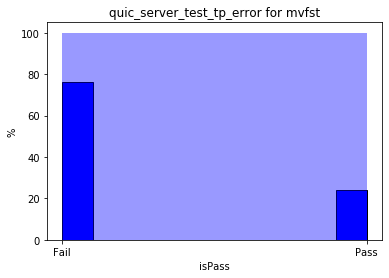

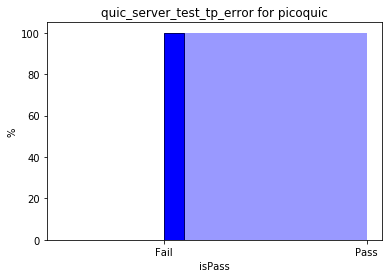

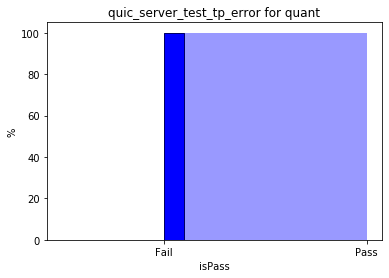

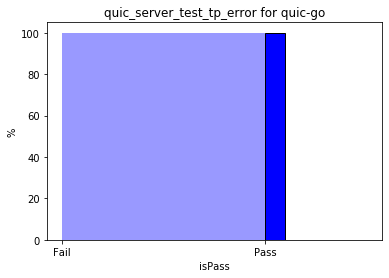

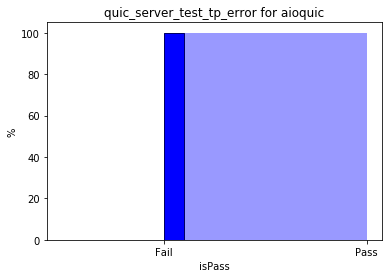

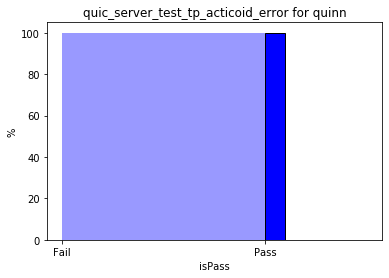

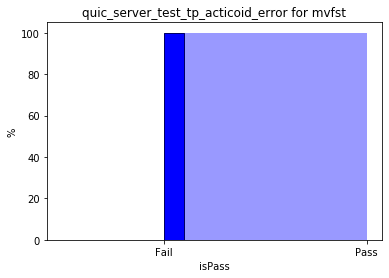

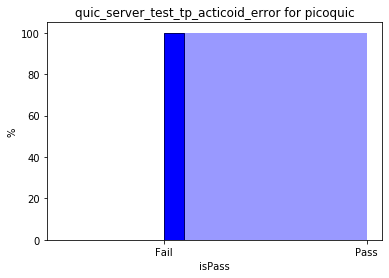

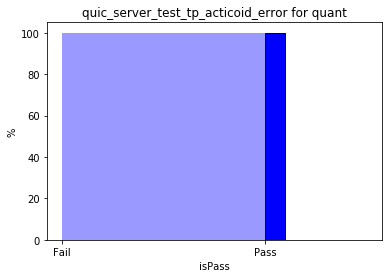

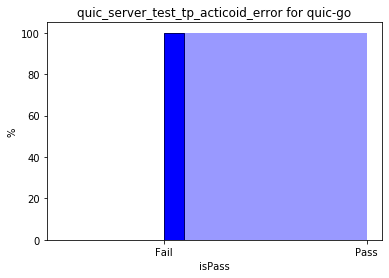

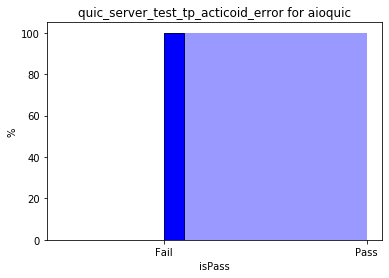

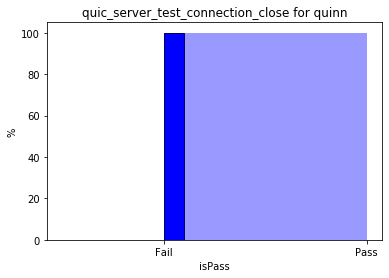

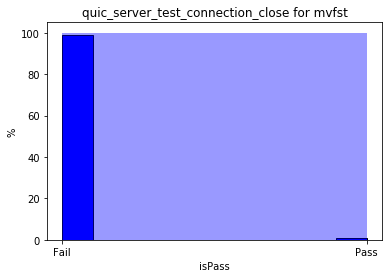

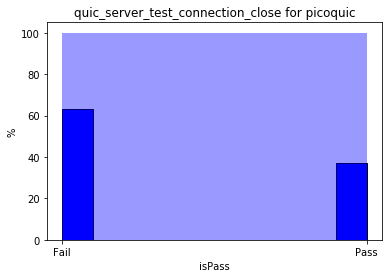

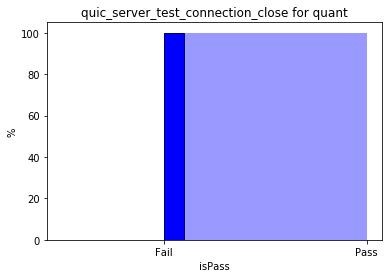

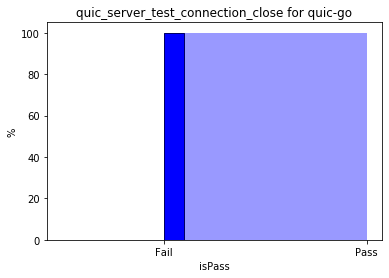

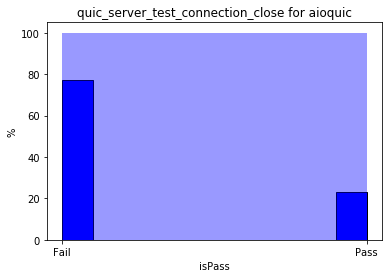

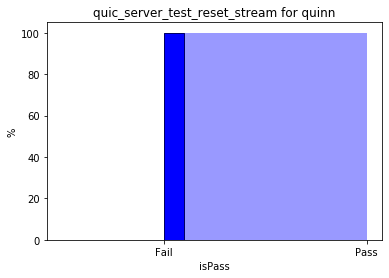

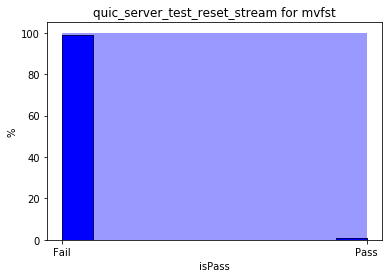

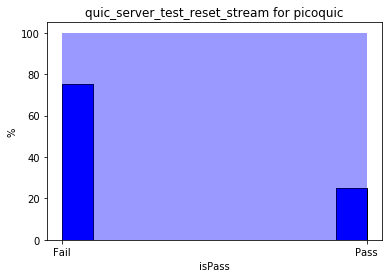

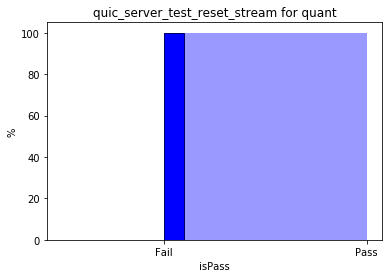

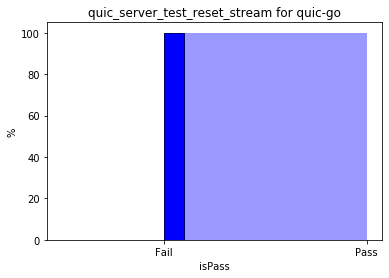

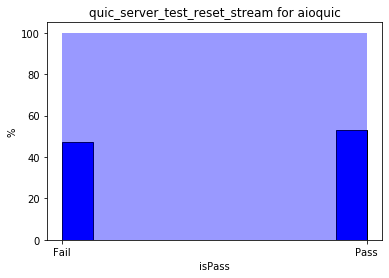

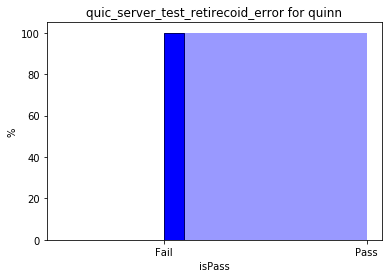

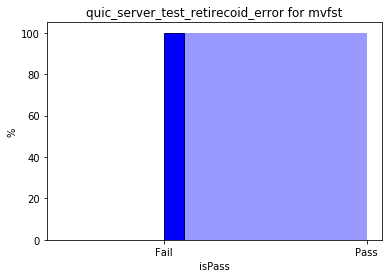

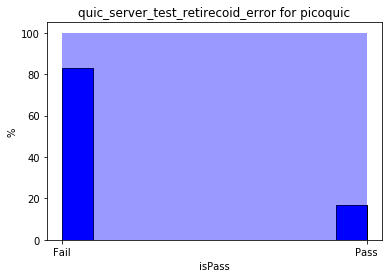

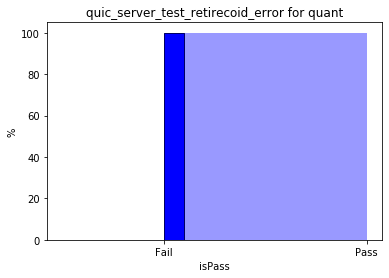

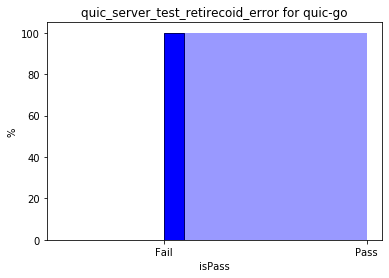

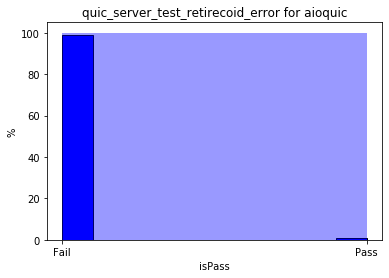

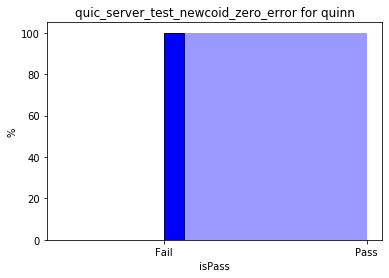

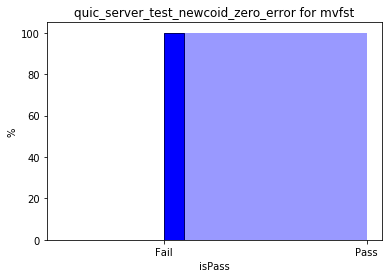

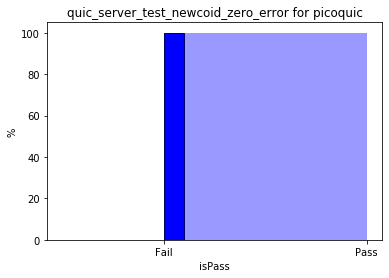

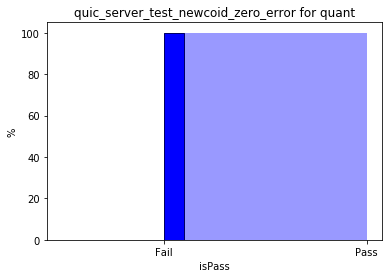

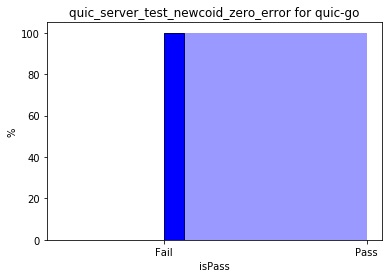

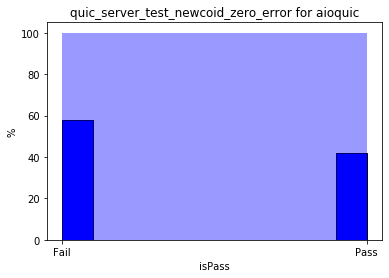

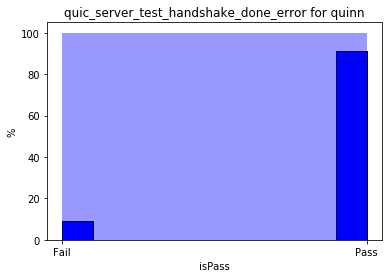

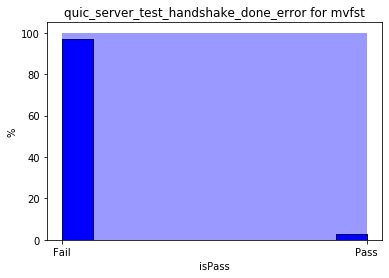

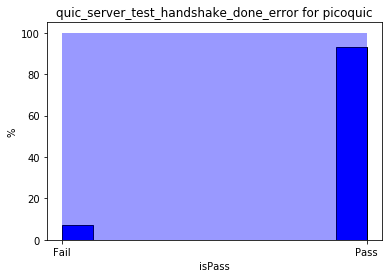

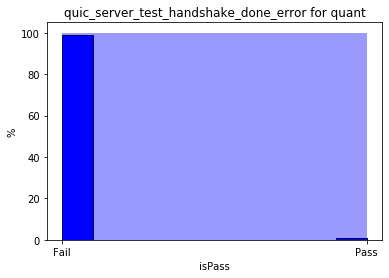

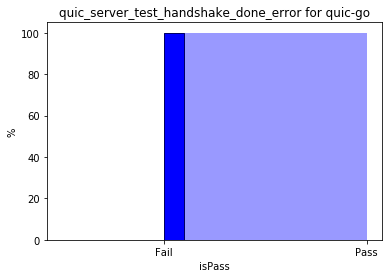

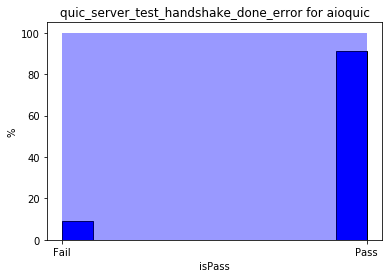

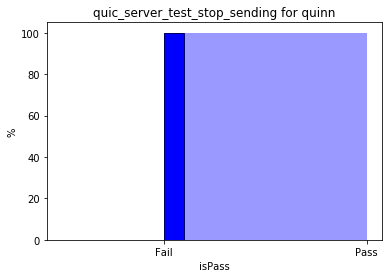

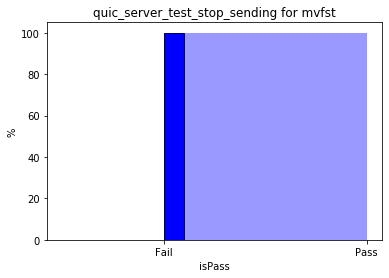

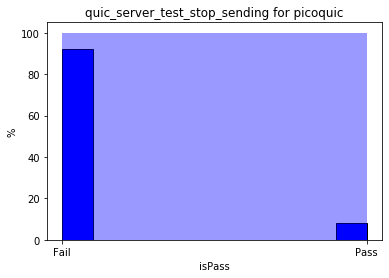

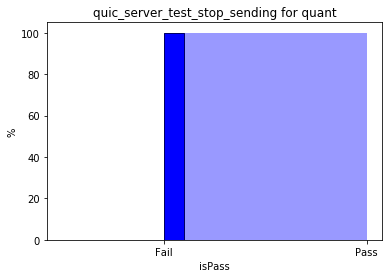

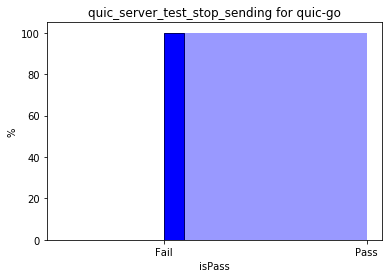

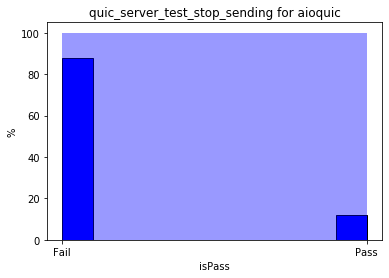

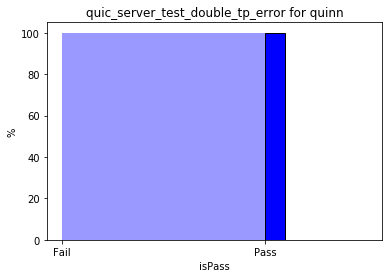

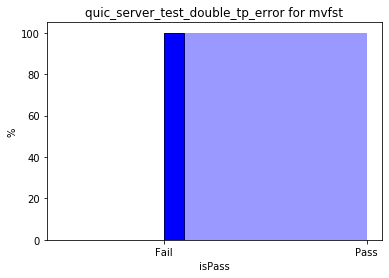

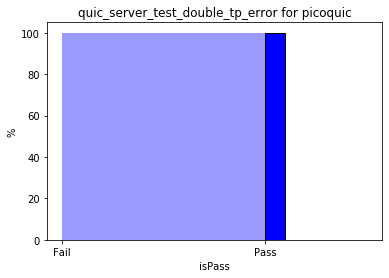

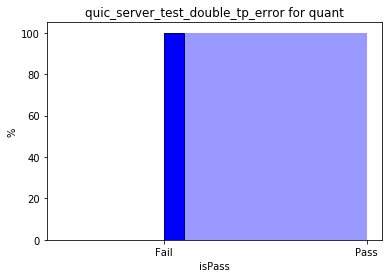

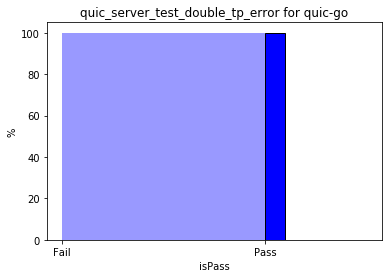

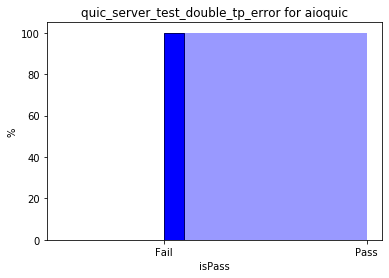

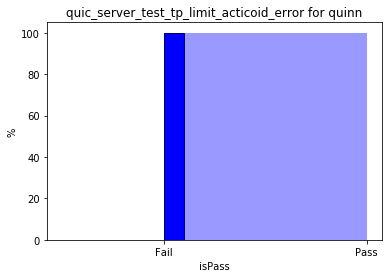

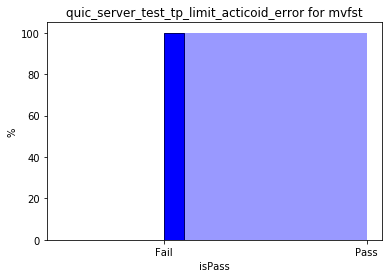

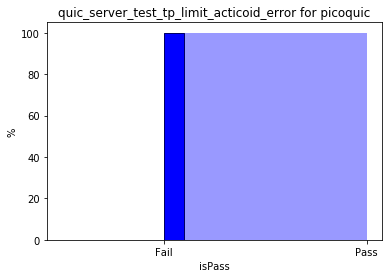

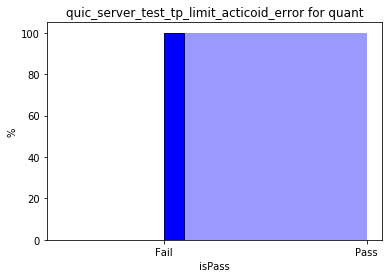

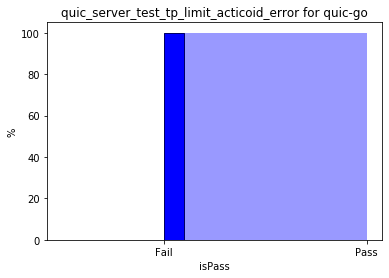

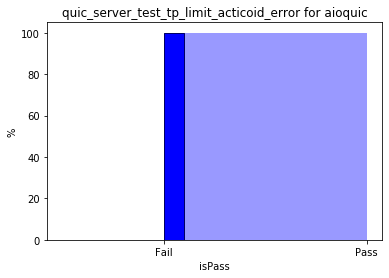

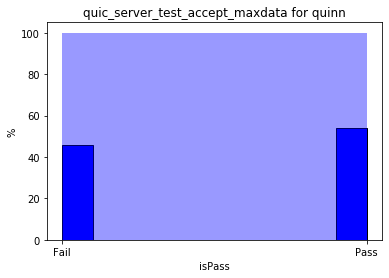

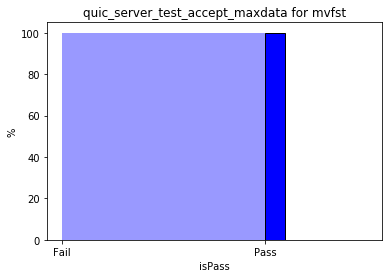

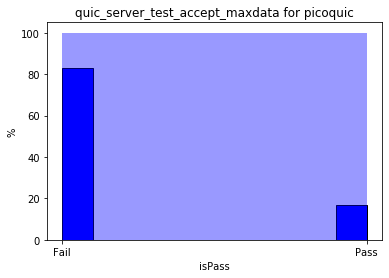

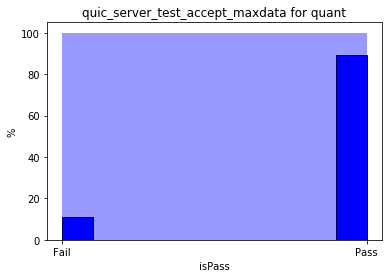

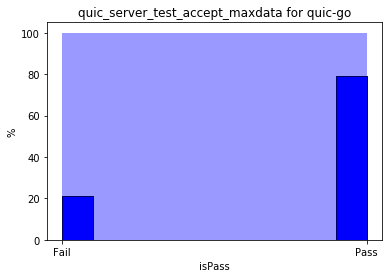

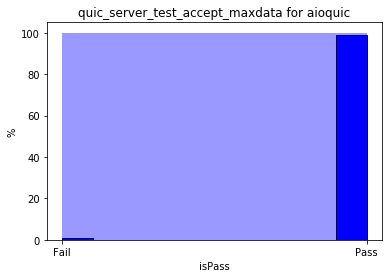

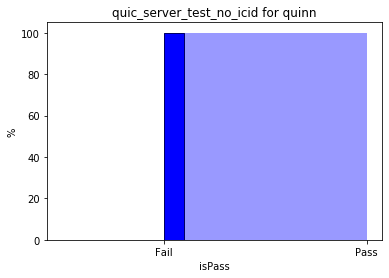

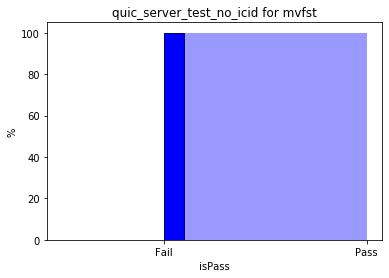

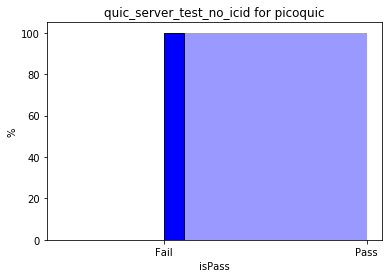

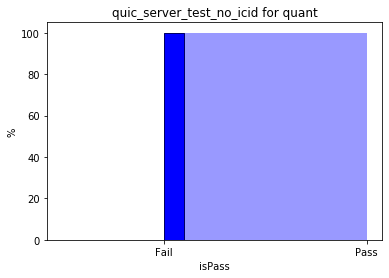

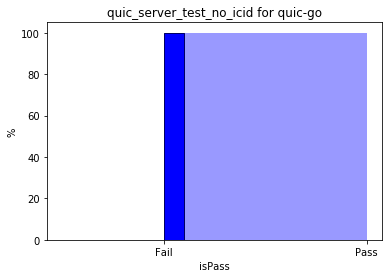

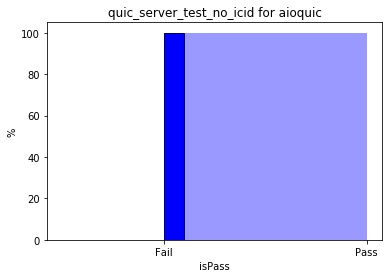

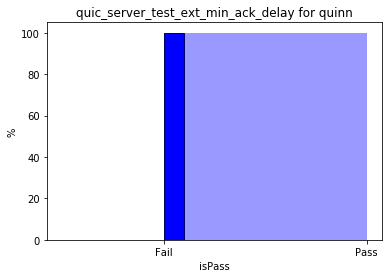

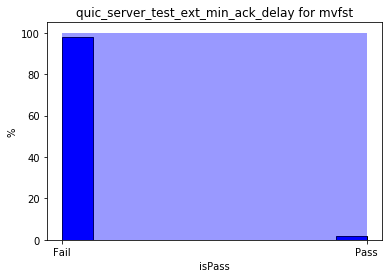

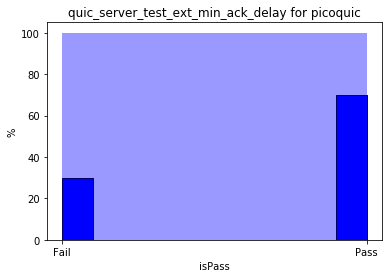

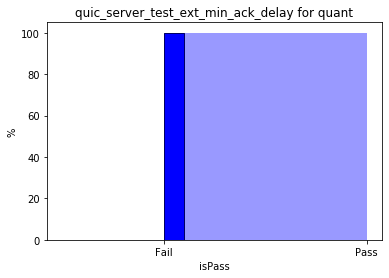

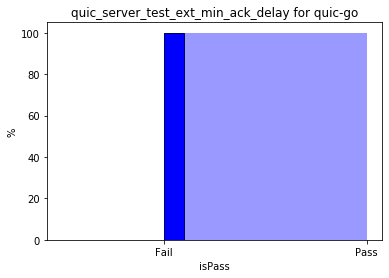

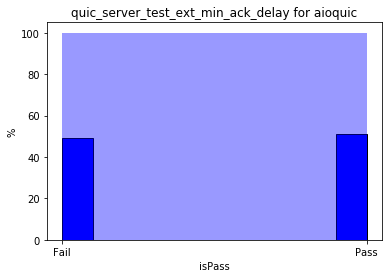

In [121]:
# Failure per test and per implementation

train_df.Implementation.unique()
tests = ['quic_server_test_stream', 'quic_server_test_unkown',
       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
       'quic_server_test_token_error', 'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream',
       'quic_server_test_retirecoid_error',
       'quic_server_test_newcoid_zero_error',
       'quic_server_test_handshake_done_error',
       'quic_server_test_stop_sending',
       'quic_server_test_double_tp_error',
       'quic_server_test_tp_limit_acticoid_error',
       'quic_server_test_accept_maxdata', 'quic_server_test_no_icid',
       'quic_server_test_ext_min_ack_delay']

servers = ['quinn',  'mvfst', 'picoquic', 'quant', 'quic-go', 'aioquic']
#plt.figure(figsize=[10,10]) 'lsquic',
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        plt.hist(subsubdf['isPass'], color = 'blue', edgecolor = 'black')

        # seaborn histogram
        sns.distplot(subsubdf['isPass'], hist=True, kde=False, 
                     color = 'blue',bins=[0, 1])
        # Add labels
        plt.xticks(np.arange(0, 1, 1))
        positions = (0, 1)
        labels = ("Fail", "Pass")
        plt.xticks(positions, labels)
        plt.title(t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('%')
        filename = 'plot/' + t + "_for_" + s + '.png'
        plt.savefig(filename)

        plt.show()
    

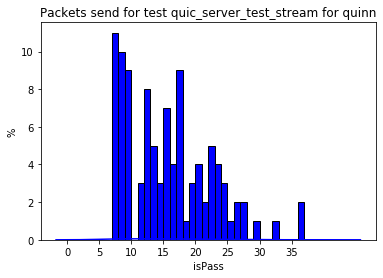

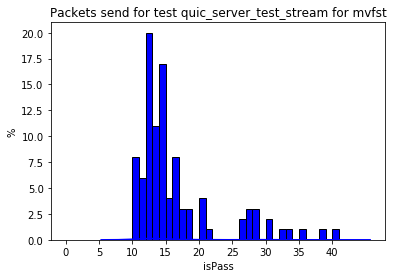

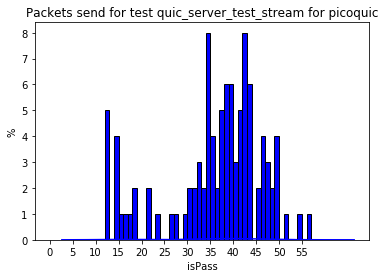

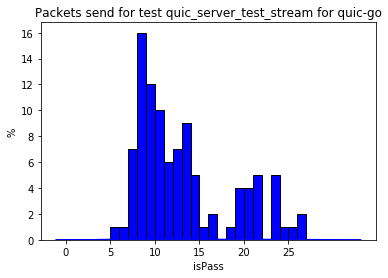

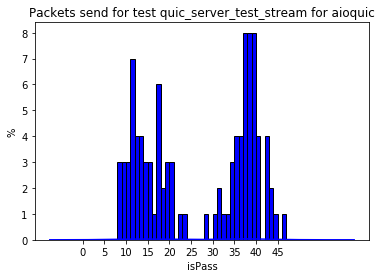

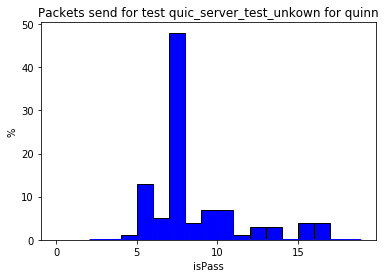

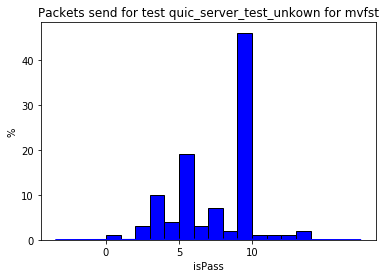

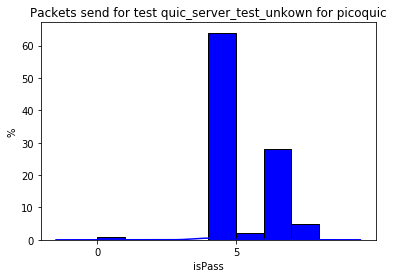

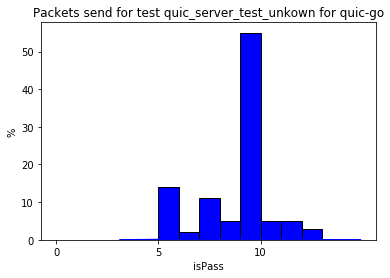

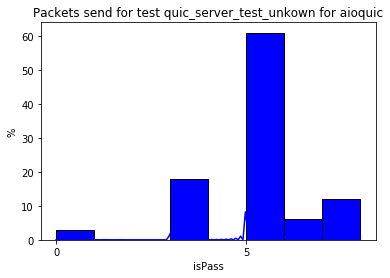

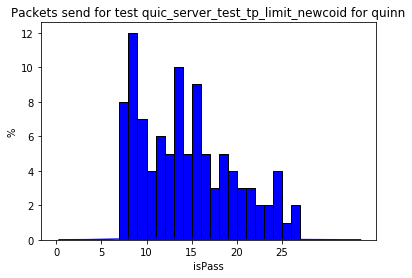

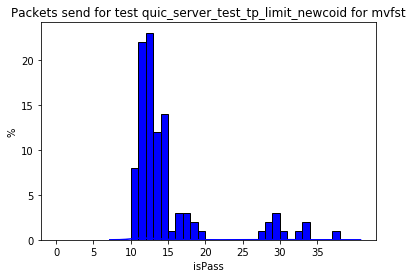

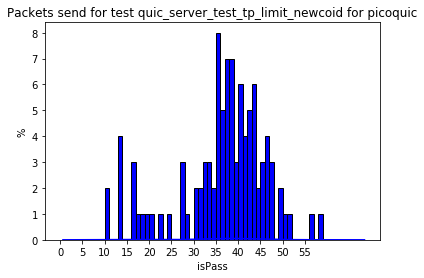

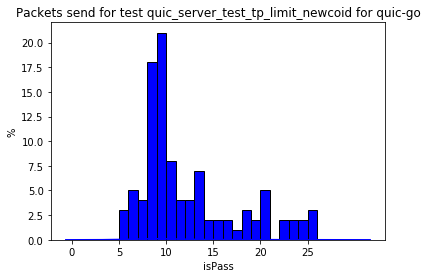

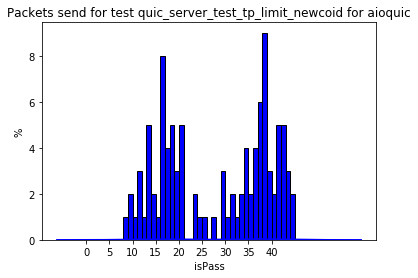

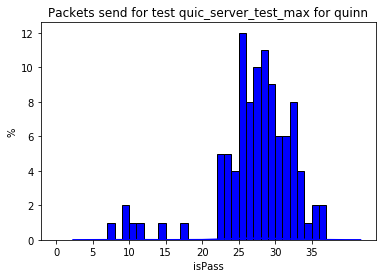

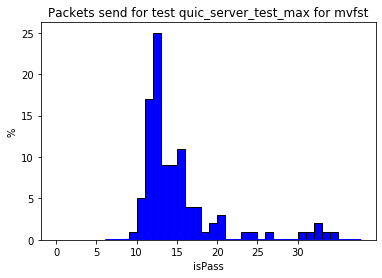

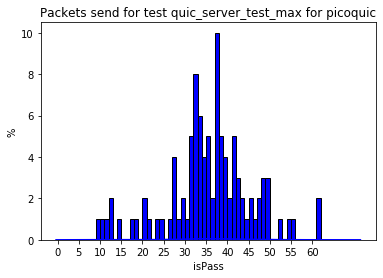

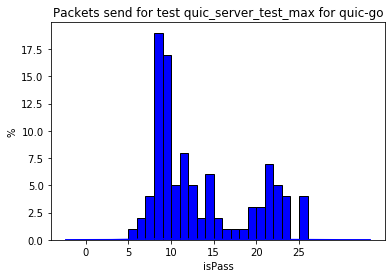

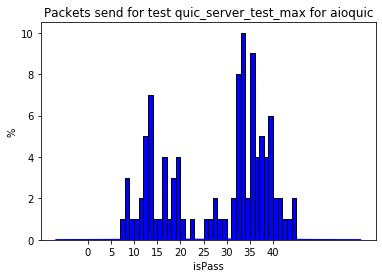

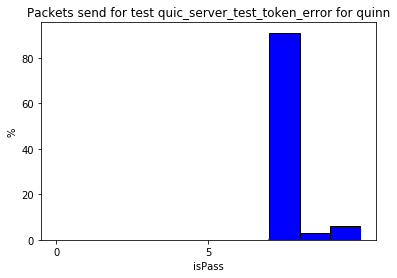

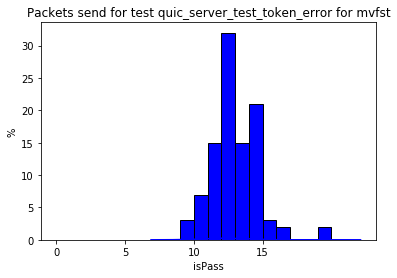

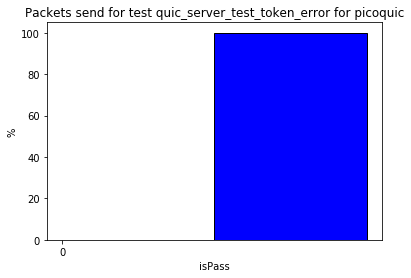

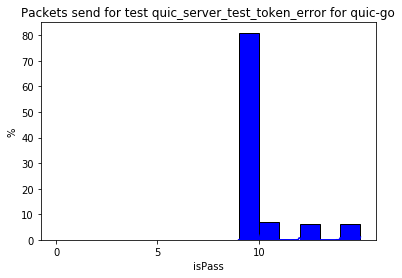

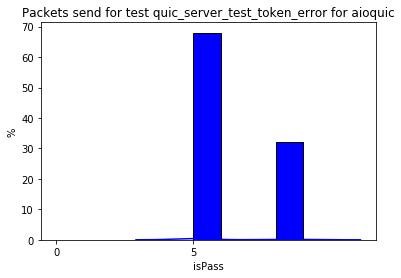

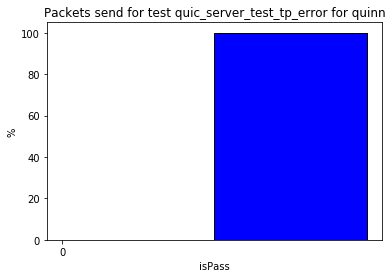

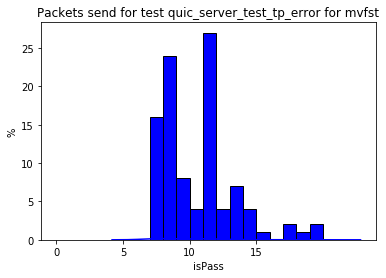

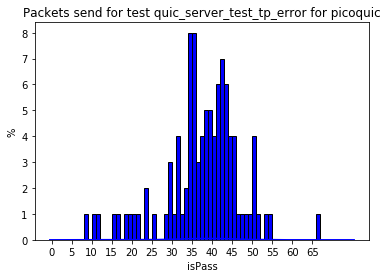

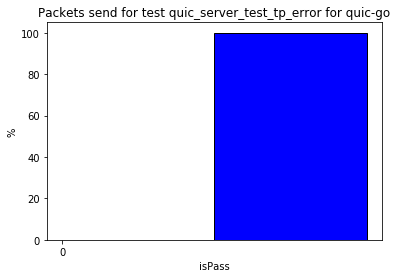

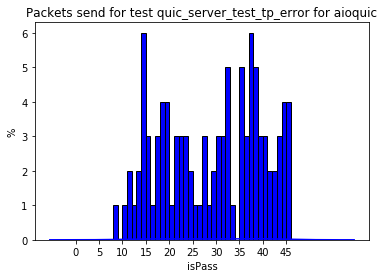

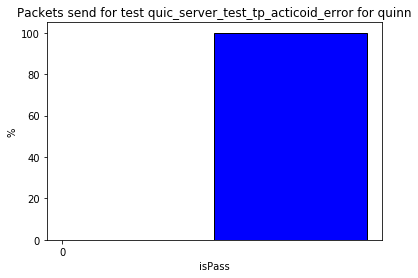

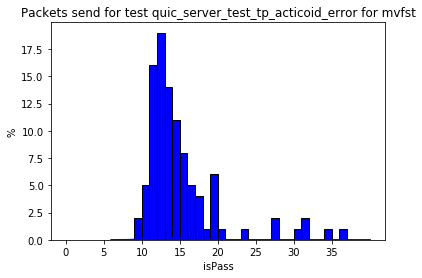

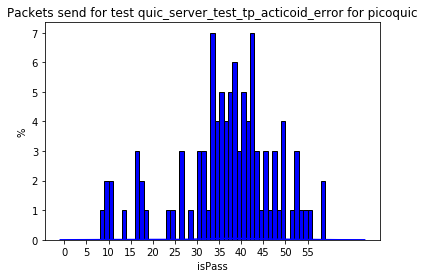

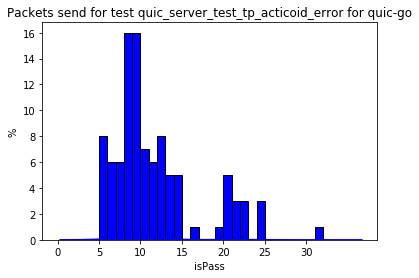

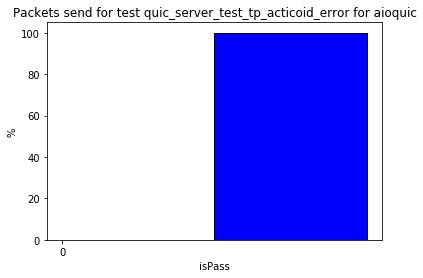

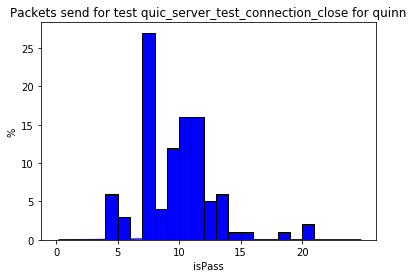

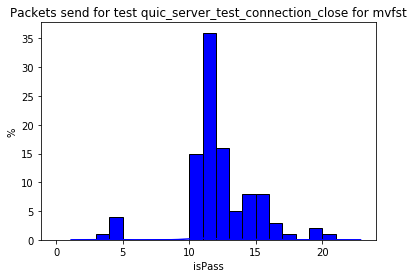

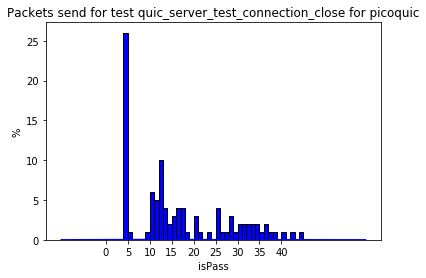

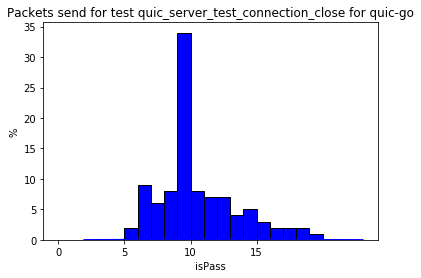

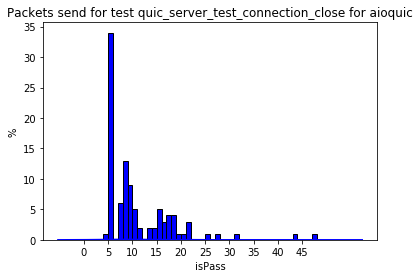

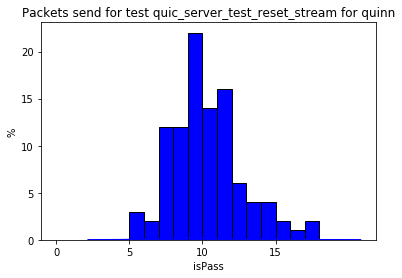

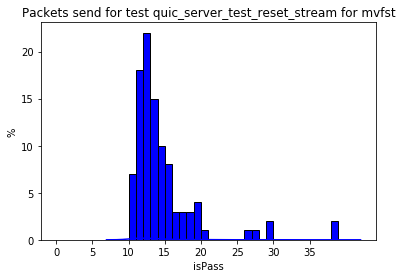

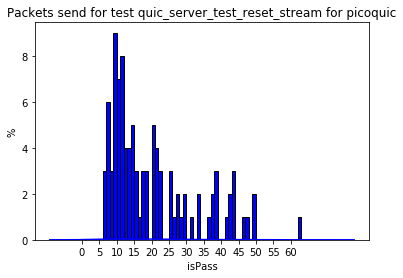

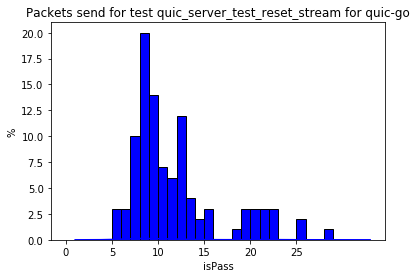

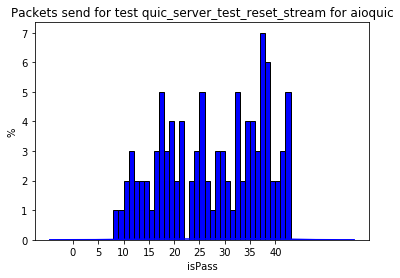

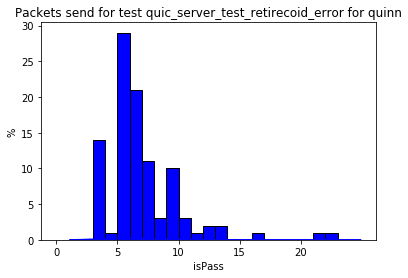

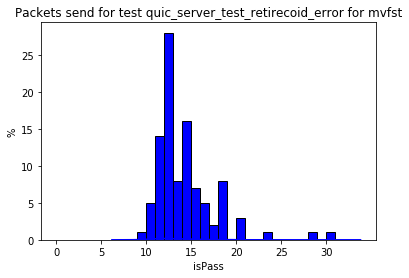

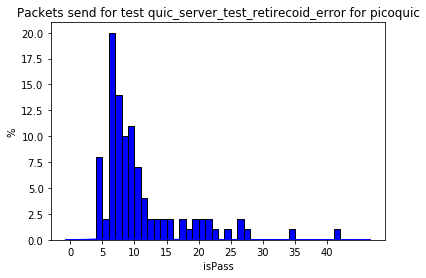

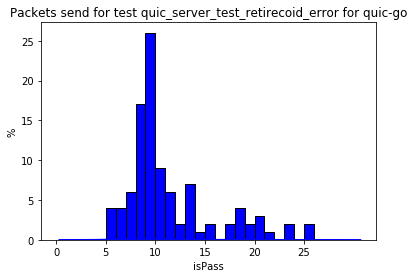

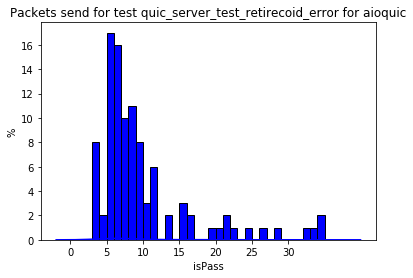

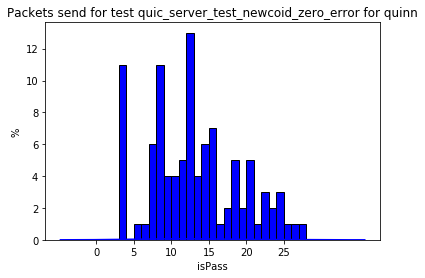

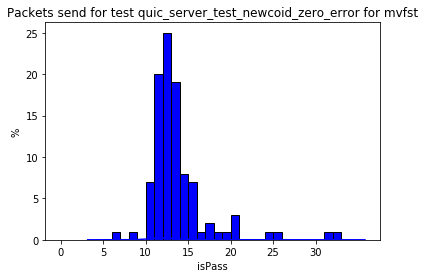

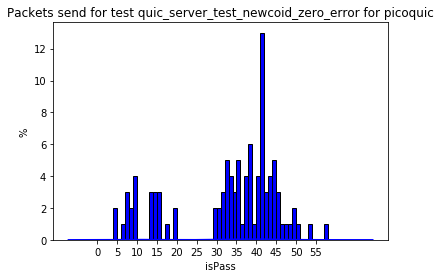

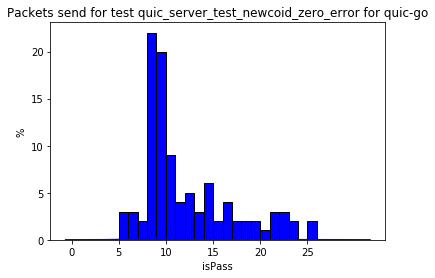

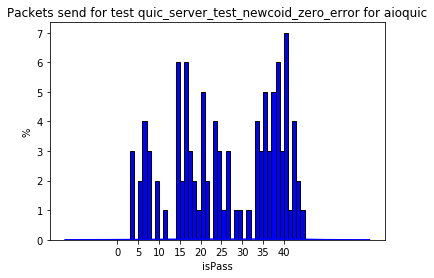

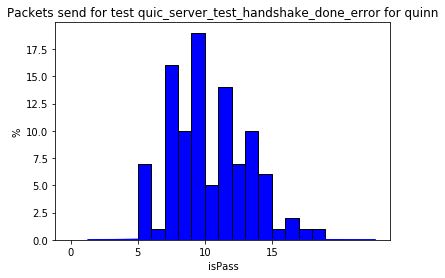

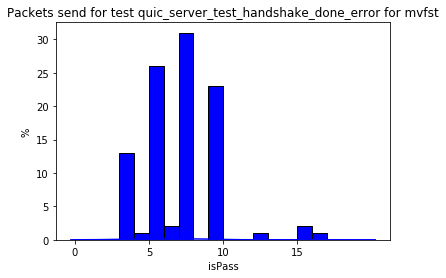

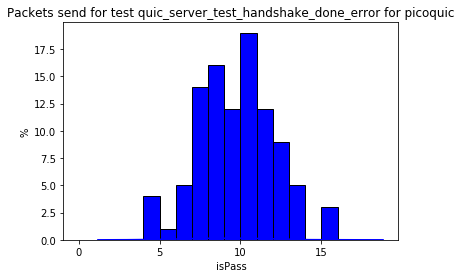

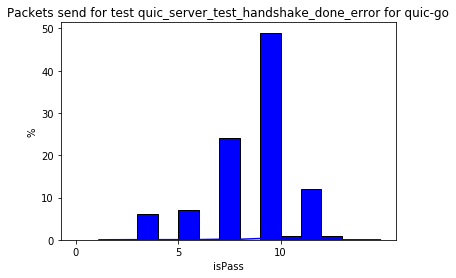

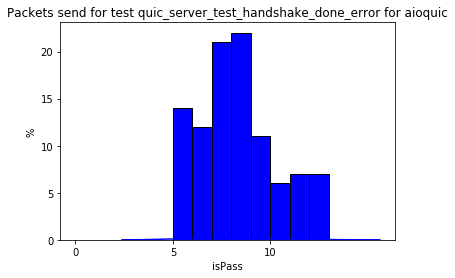

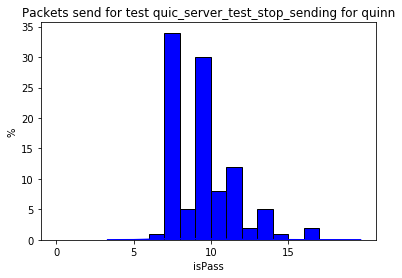

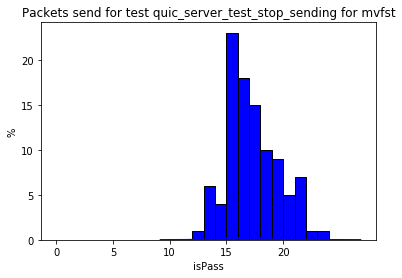

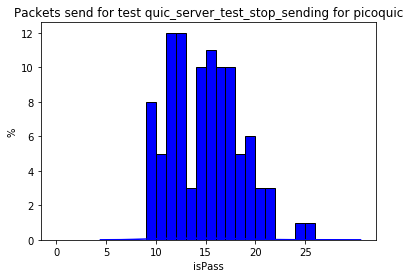

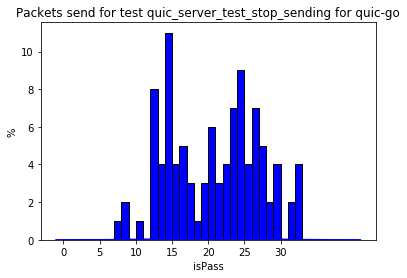

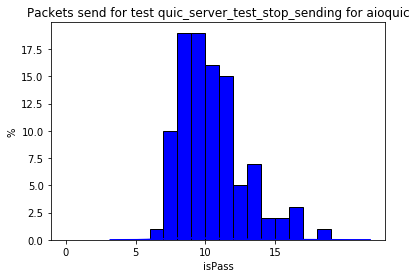

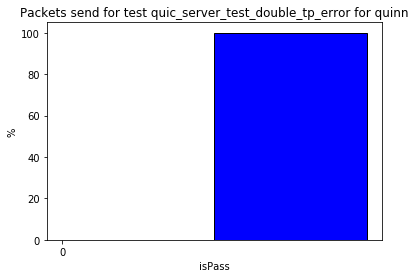

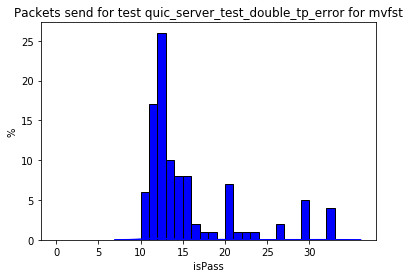

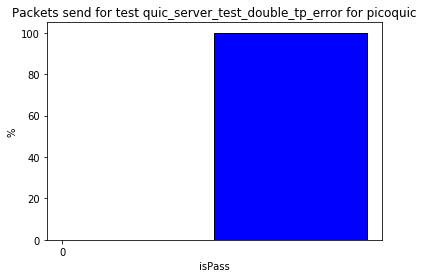

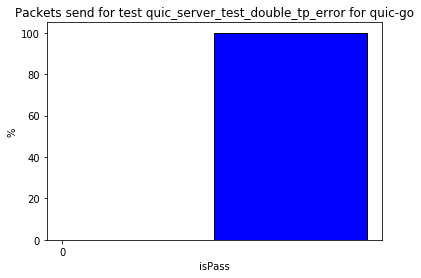

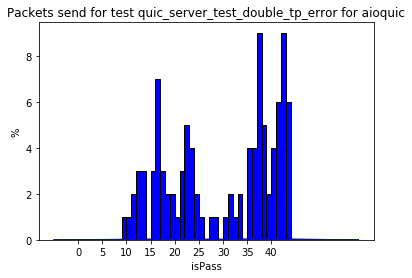

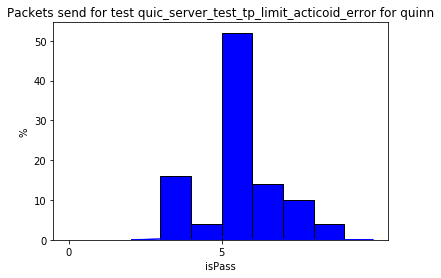

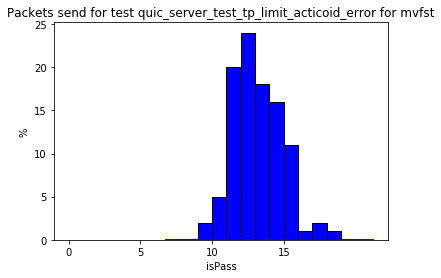

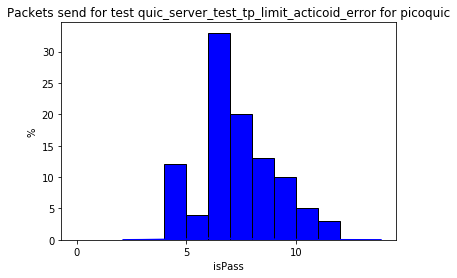

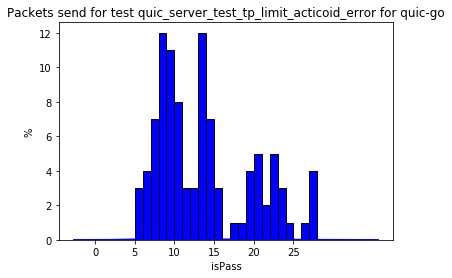

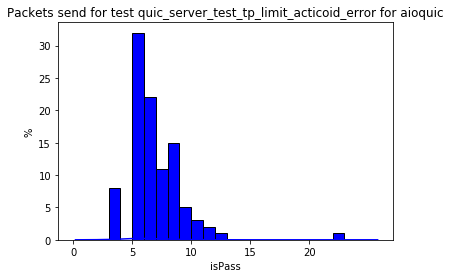

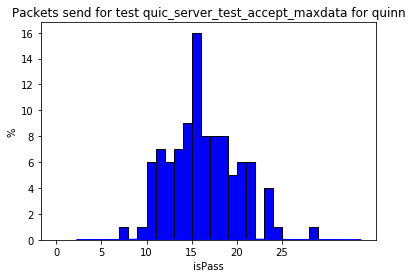

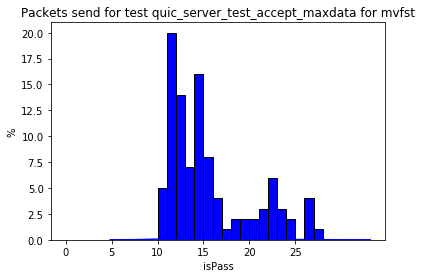

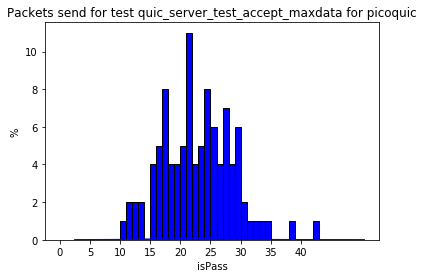

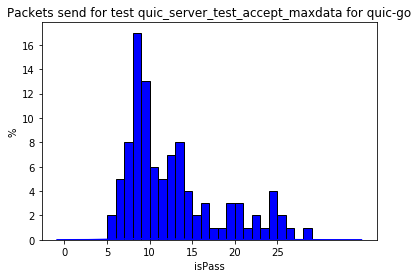

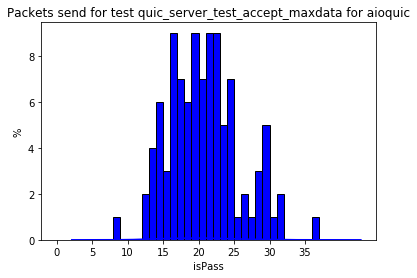

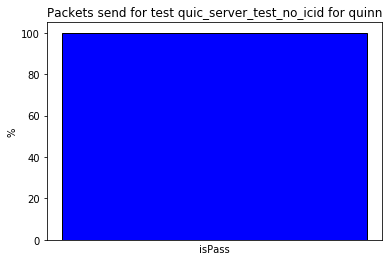

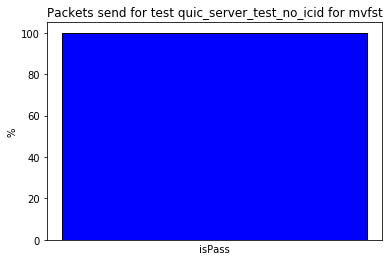

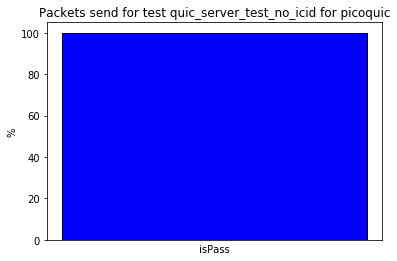

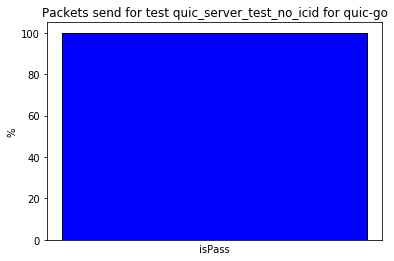

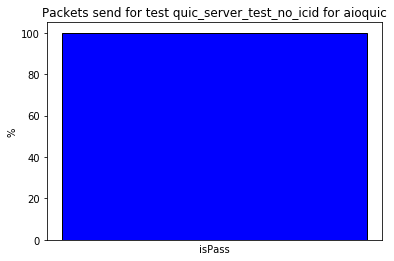

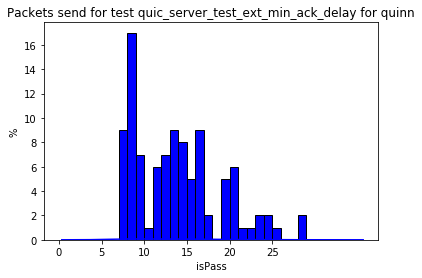

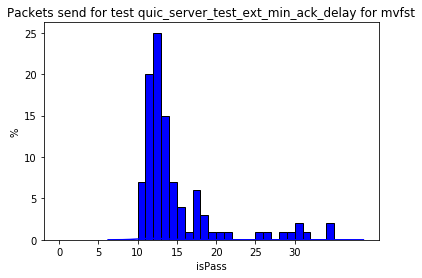

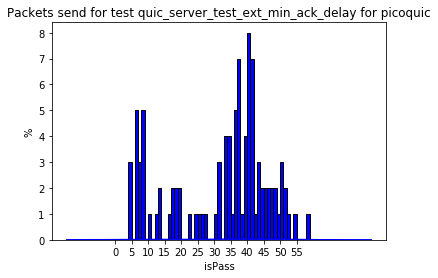

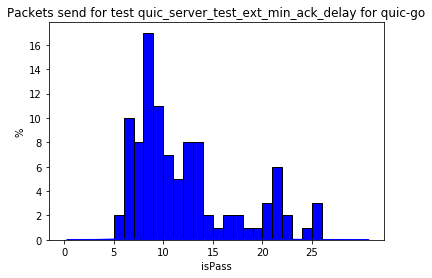

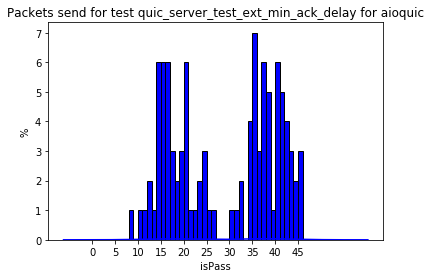

In [168]:
for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        max_value = subsubdf["NbPktSend"].max() 
    
        plt.hist(subsubdf['NbPktSend'], color = 'blue', edgecolor = 'black',
                 range = [0,max_value],bins=max(int(max_value),1))

        # seaborn histogram
        sns.distplot(subsubdf['NbPktSend'], hist=False,
                     kde=True, color = 'blue')
        # Add labels
        plt.xticks(np.arange(0, int(max_value),5))
        # Add labels
        # plt.xticks(np.arange(0, 1, 1))
        # positions = (0, 1)
        # labels = ("Fail", "Pass")
        # plt.xticks(positions, labels)
        plt.title("Packets send for test " + t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('%')
        filename = 'plot/' + "packets_" + t + "_for_" + s + '.png'
        plt.savefig(filename)

        plt.show()

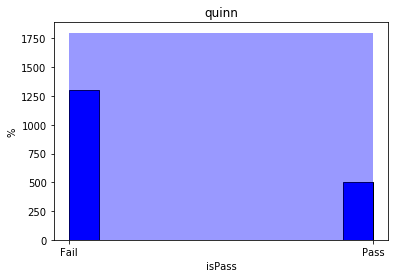

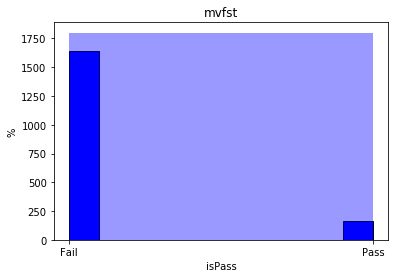

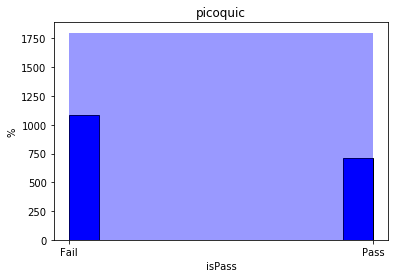

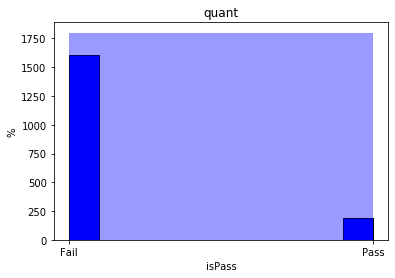

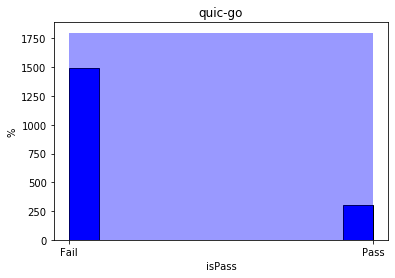

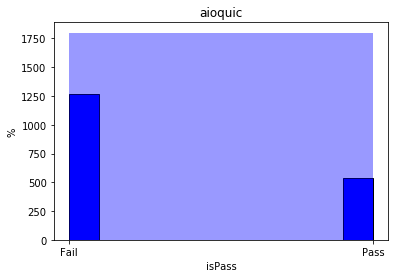

In [122]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.distplot(subdf['isPass'], hist=True, kde=False, 
                 color = 'blue',bins=[0, 1])
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('%')
    filename = 'plot/' + t + '.png'
    plt.savefig(filename)
    plt.show()
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


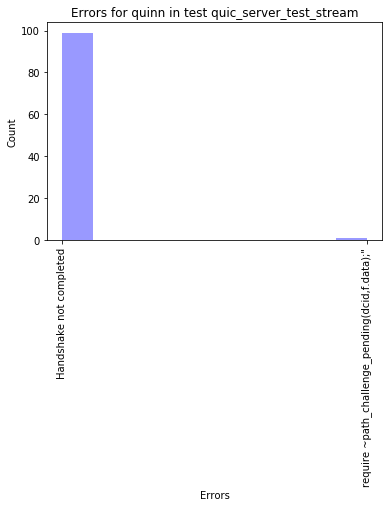

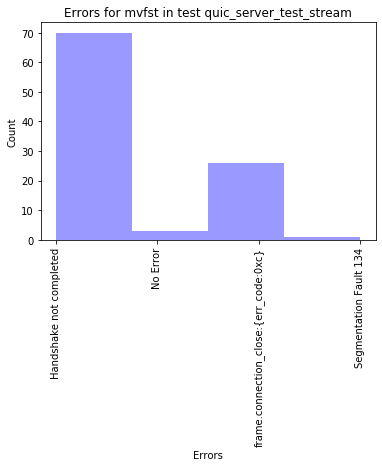

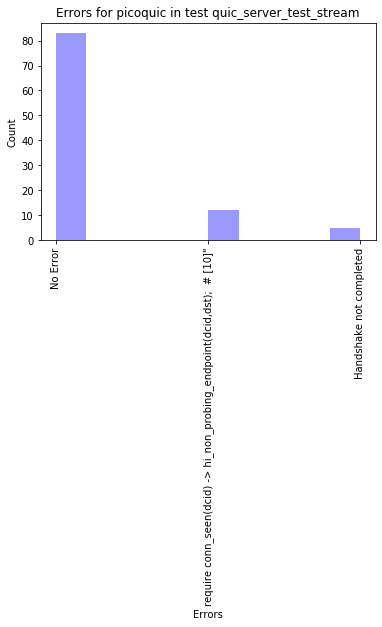

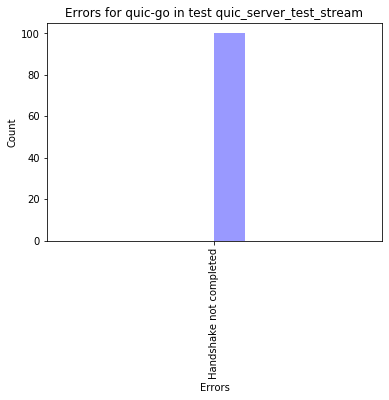

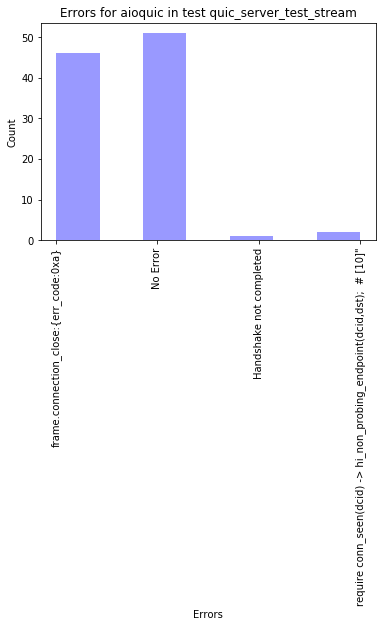

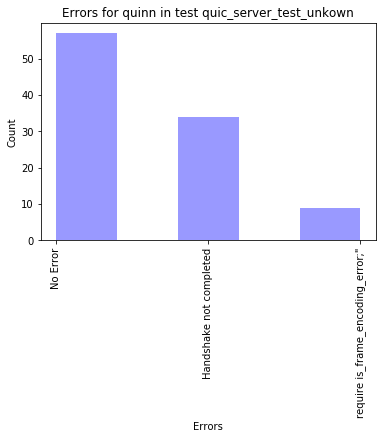

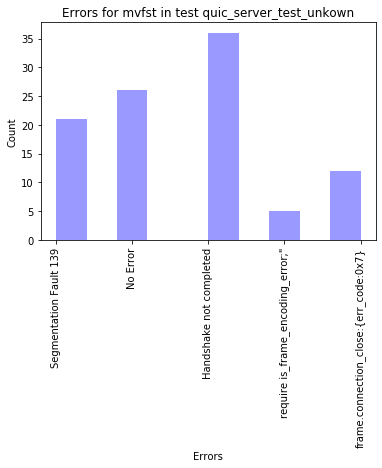

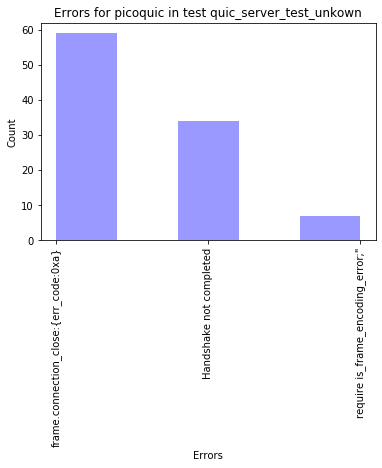

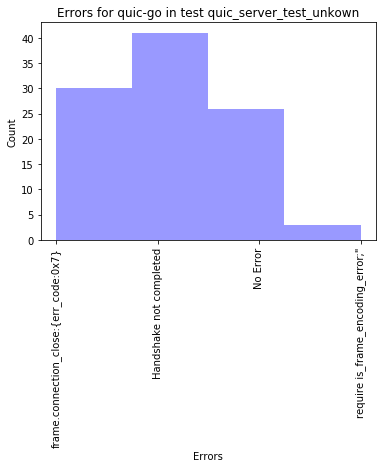

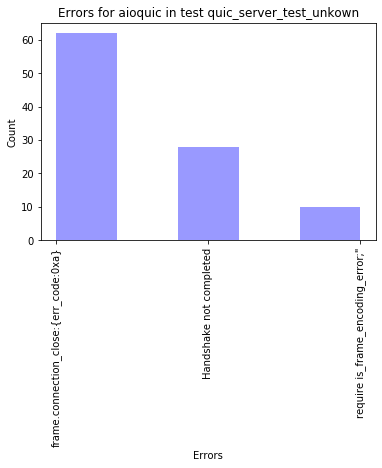

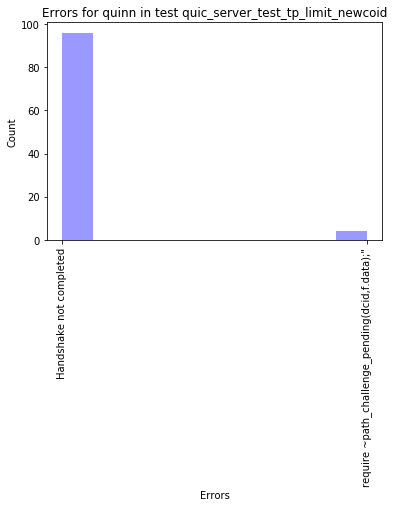

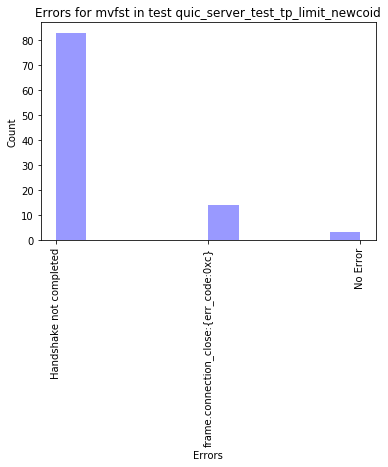

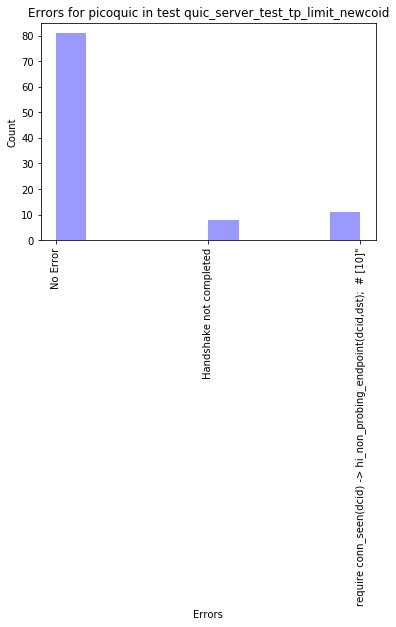

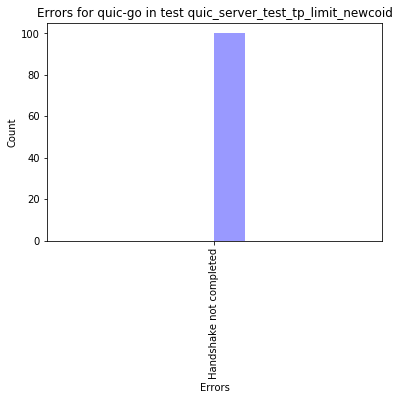

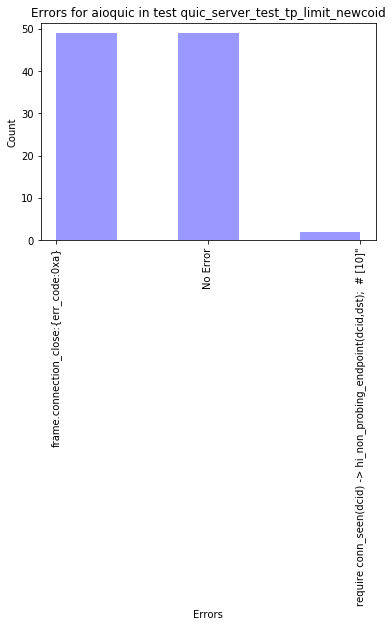

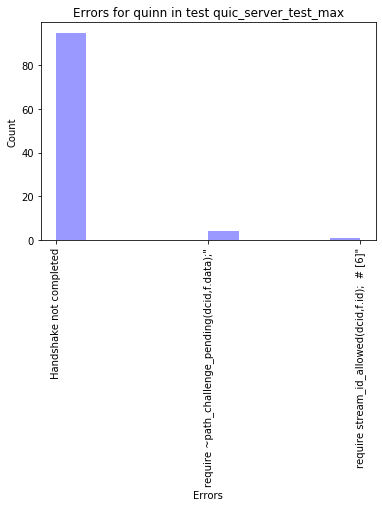

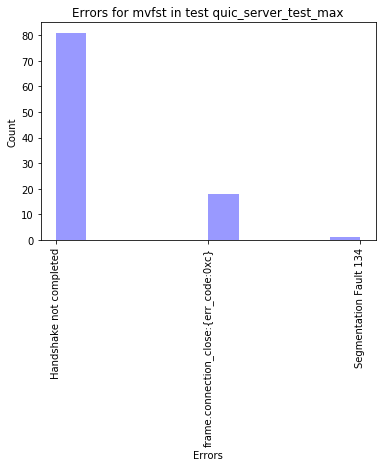

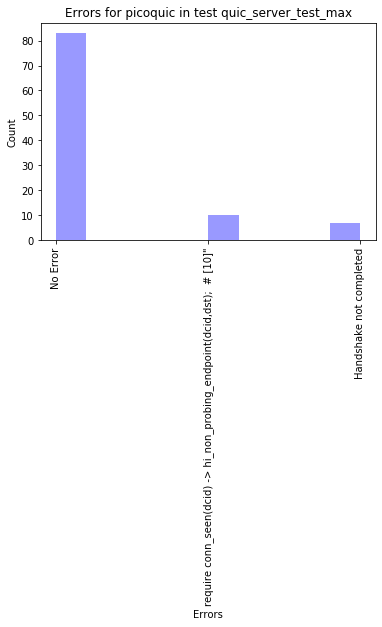

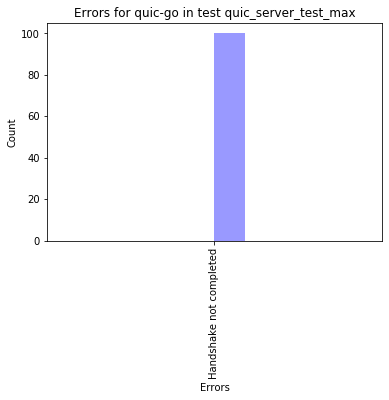

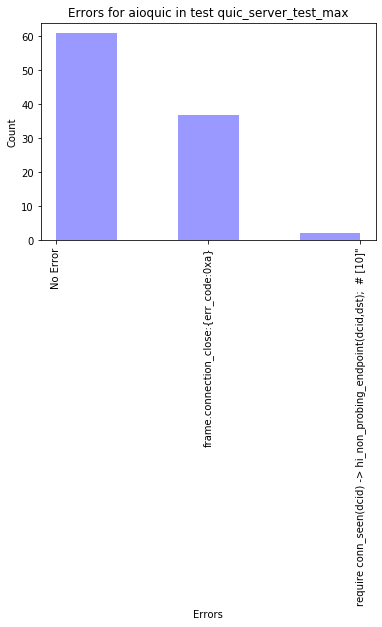

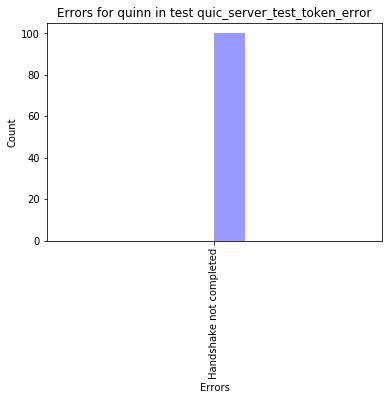

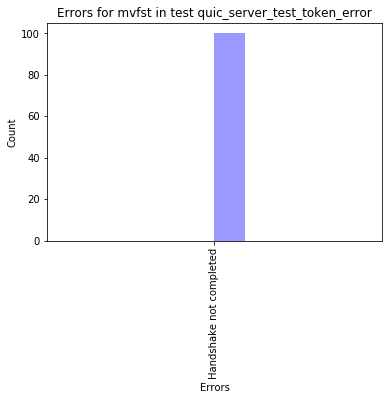

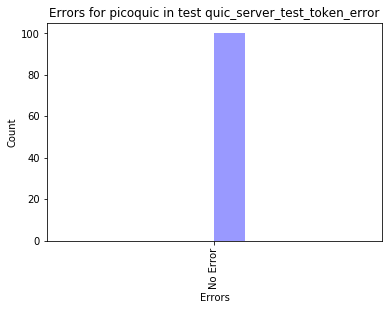

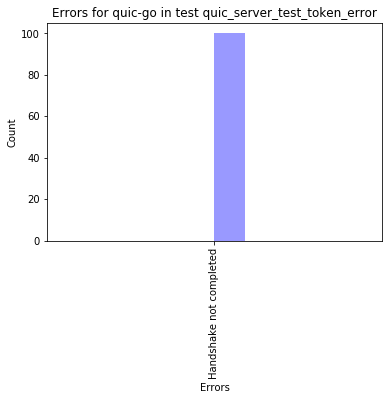

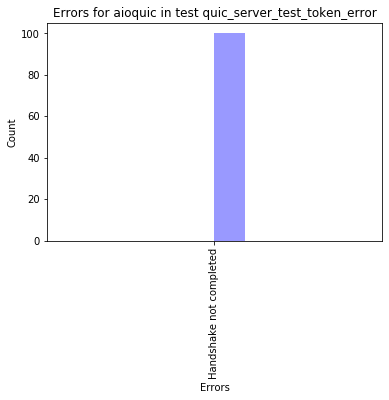

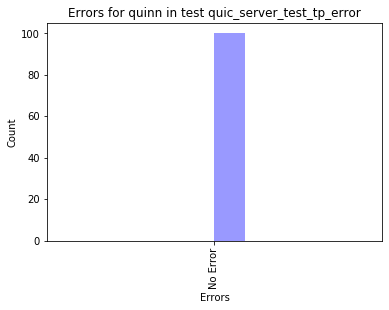

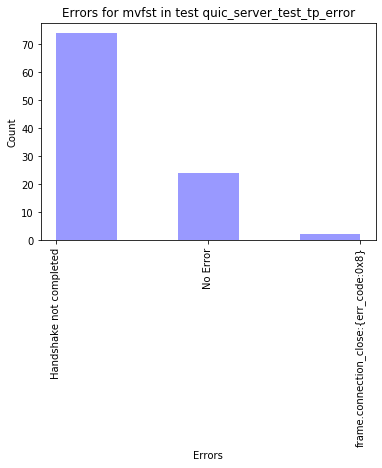

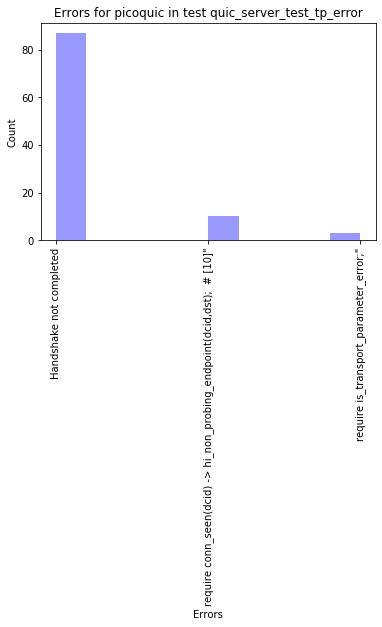

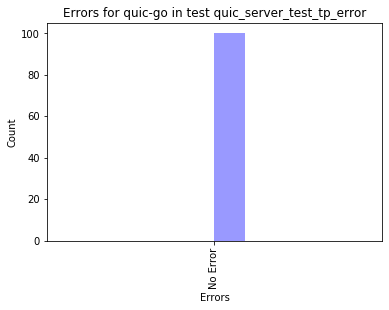

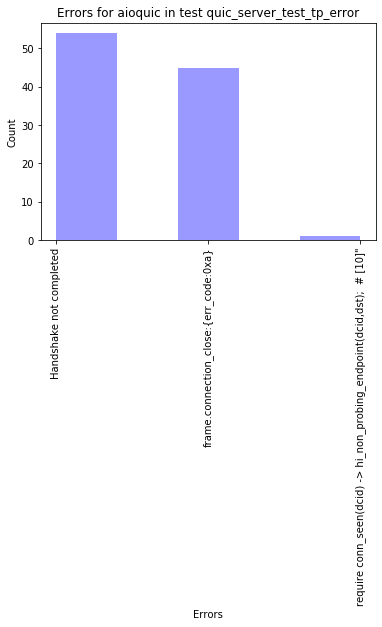

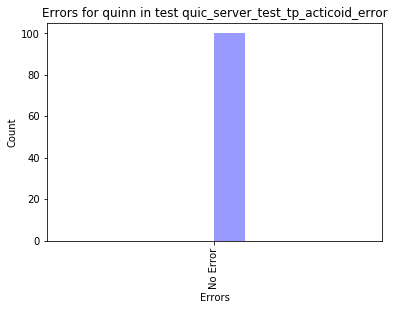

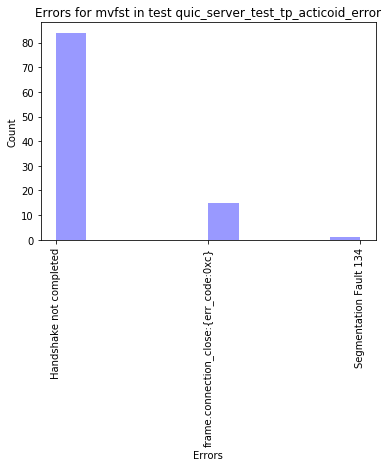

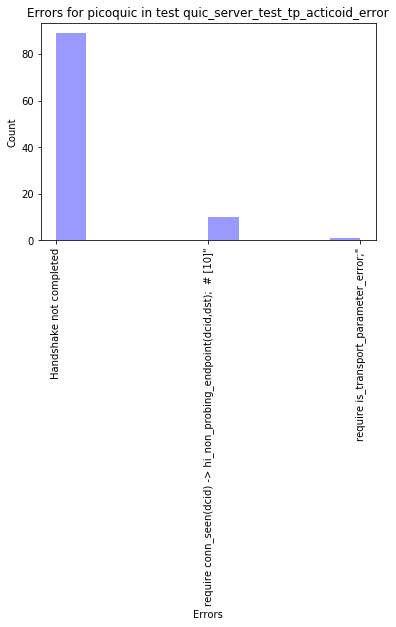

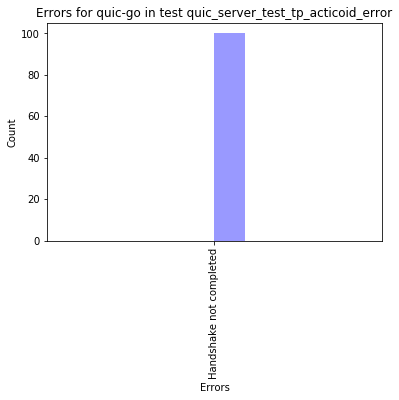

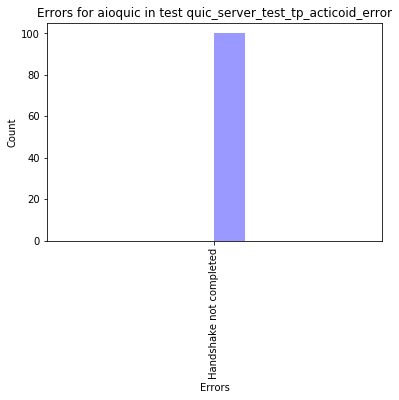

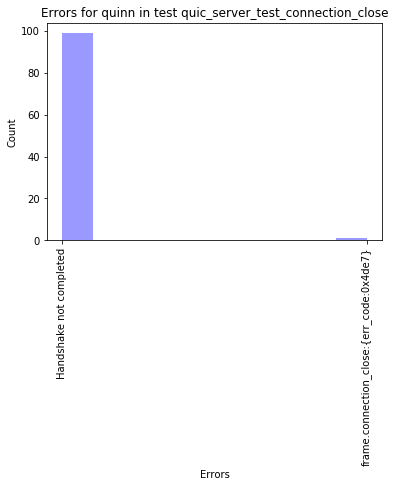

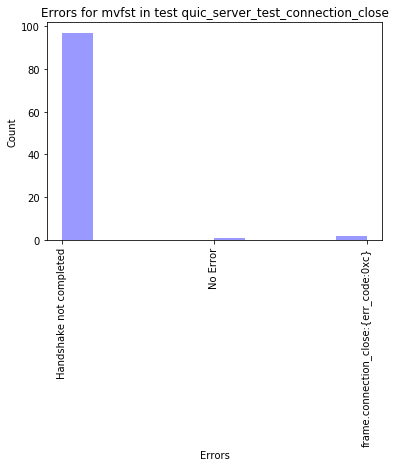

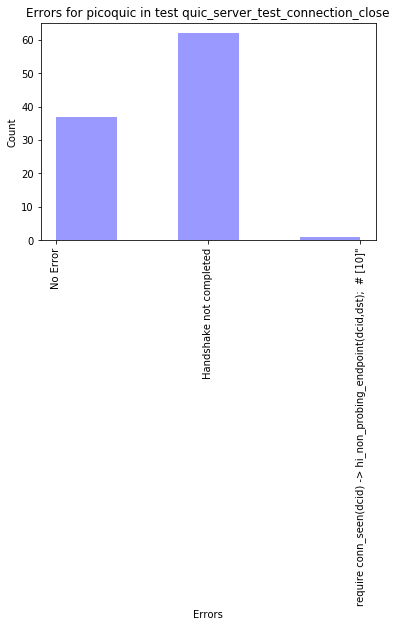

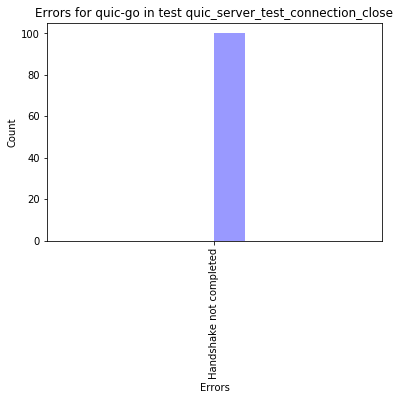

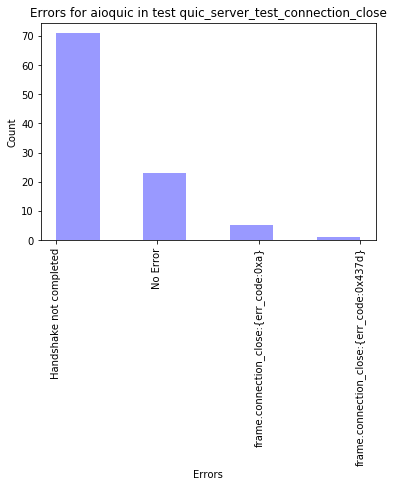

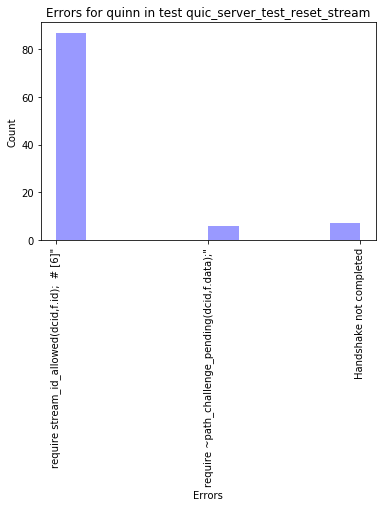

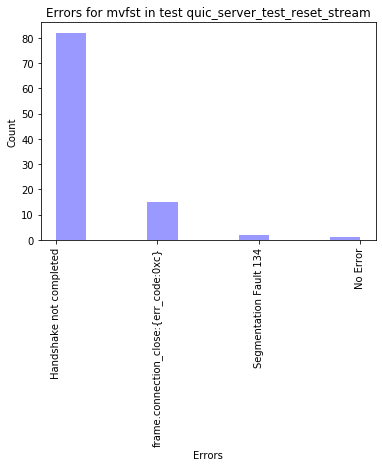

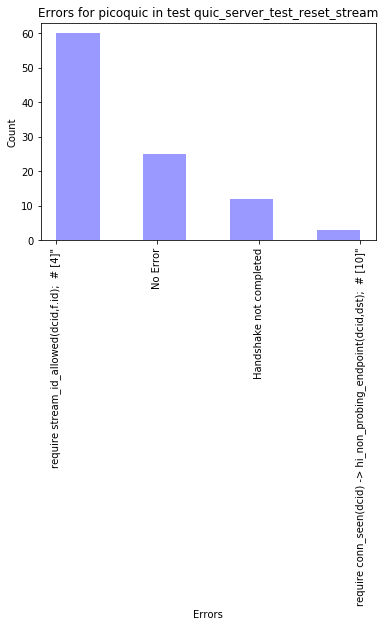

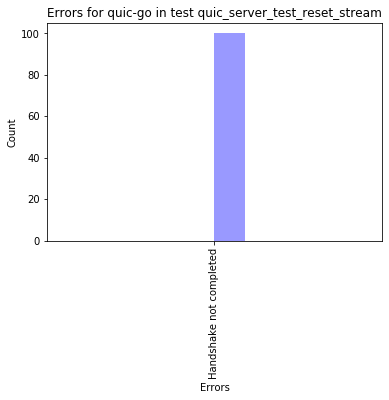

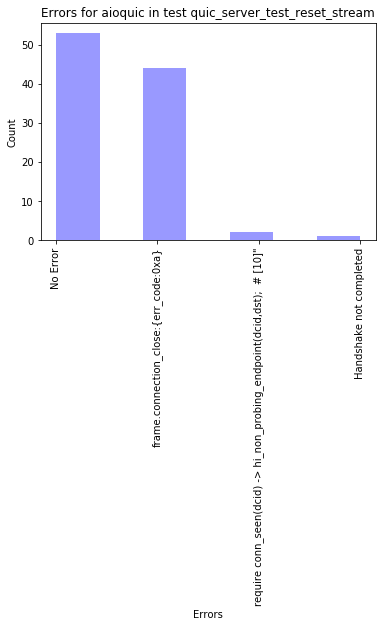

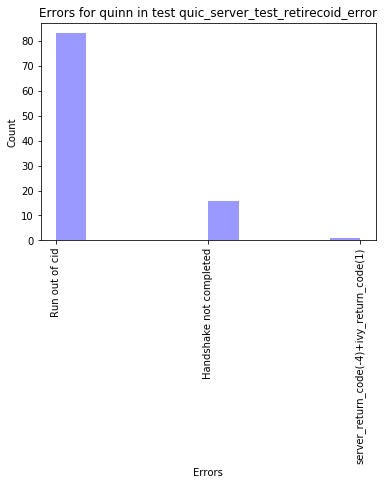

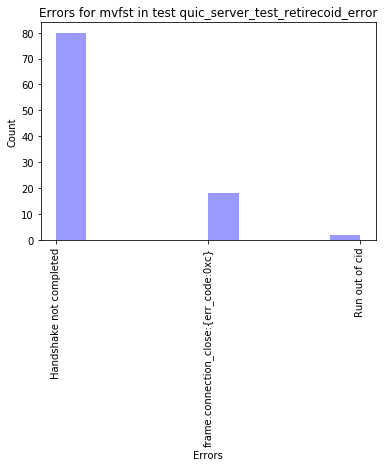

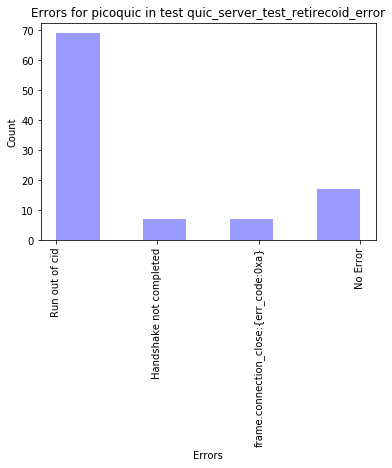

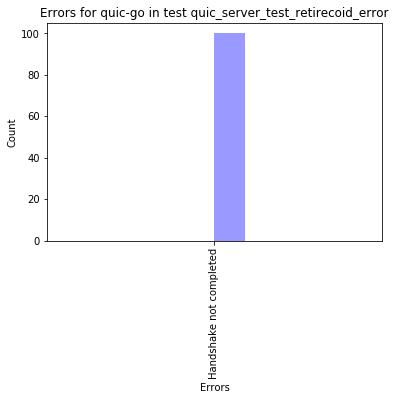

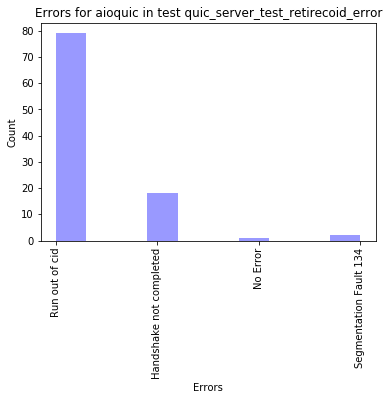

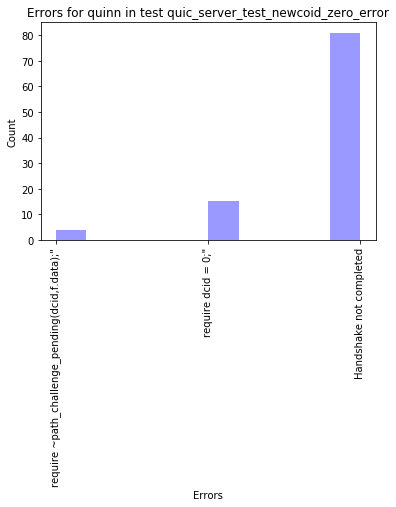

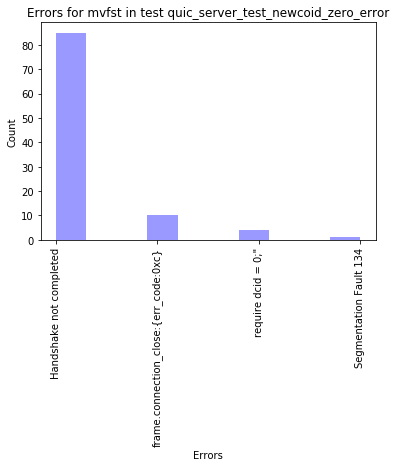

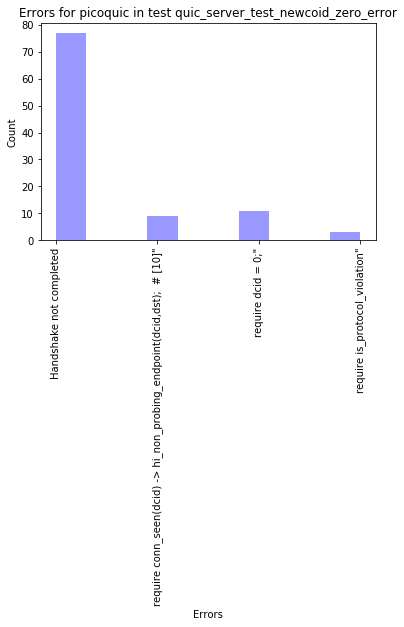

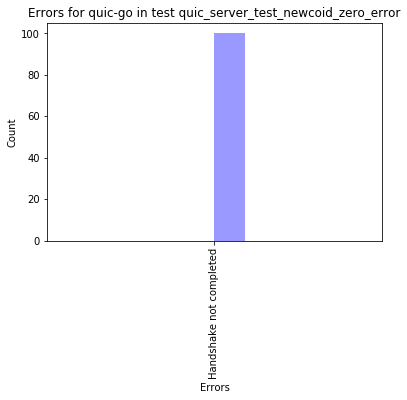

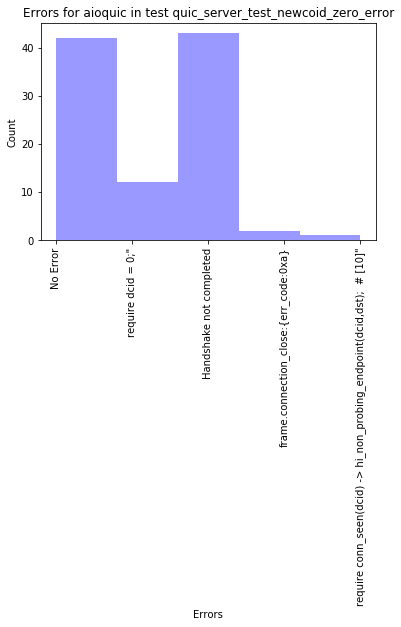

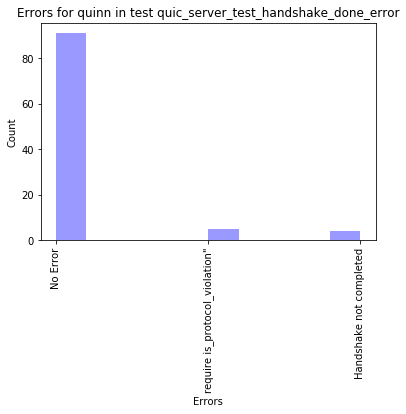

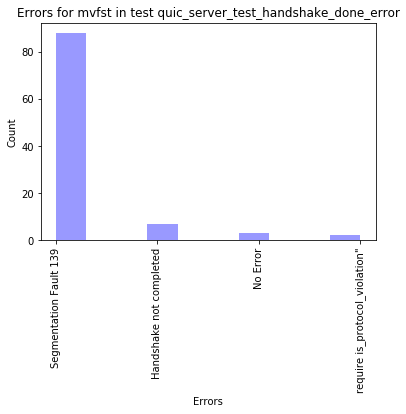

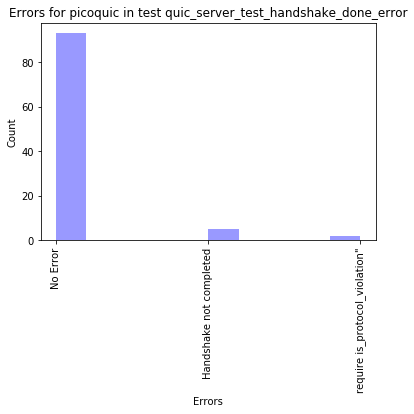

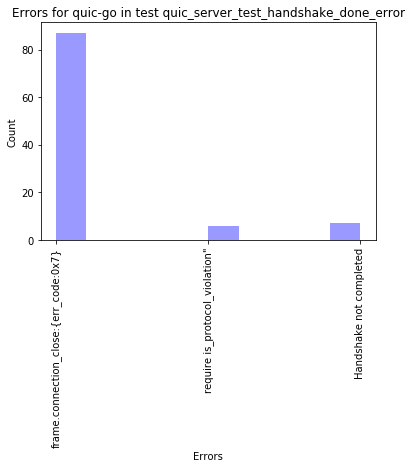

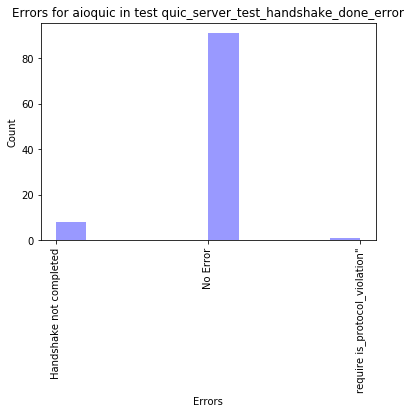

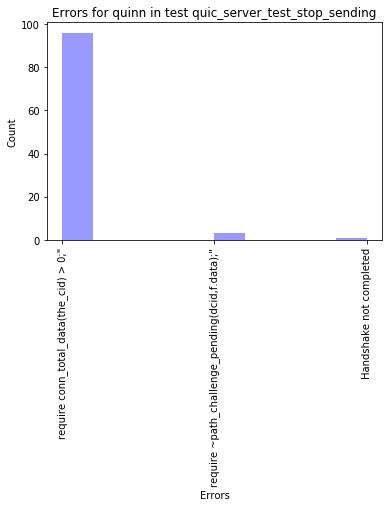

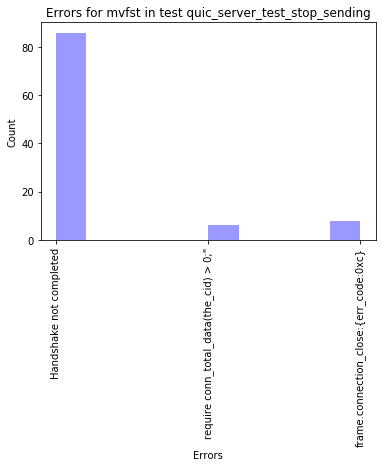

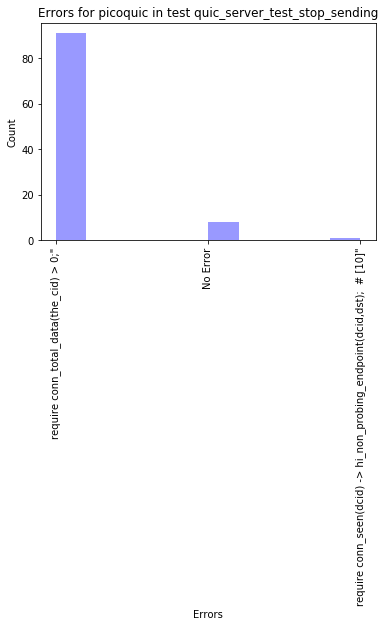

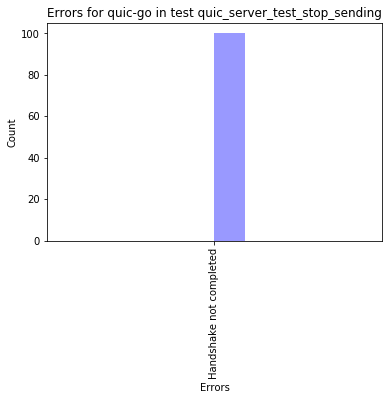

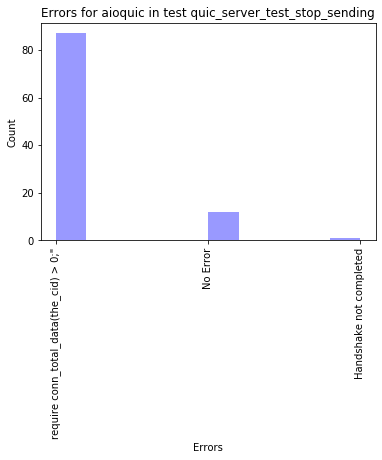

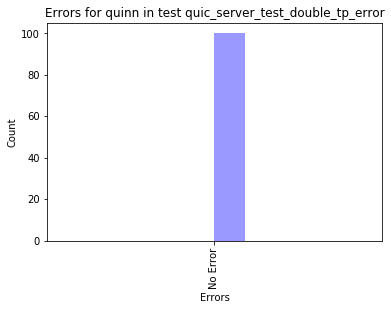

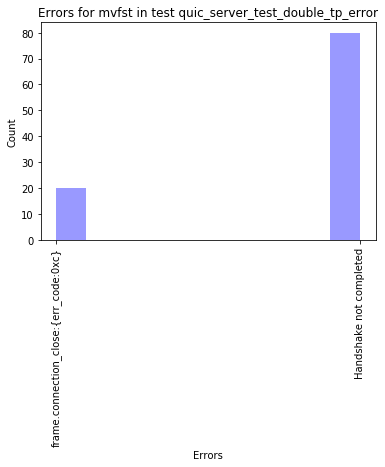

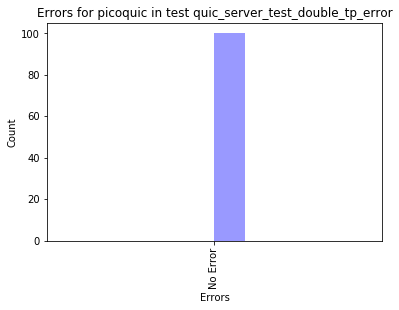

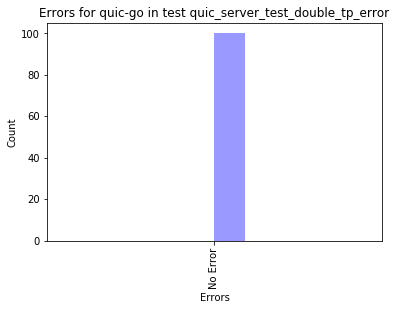

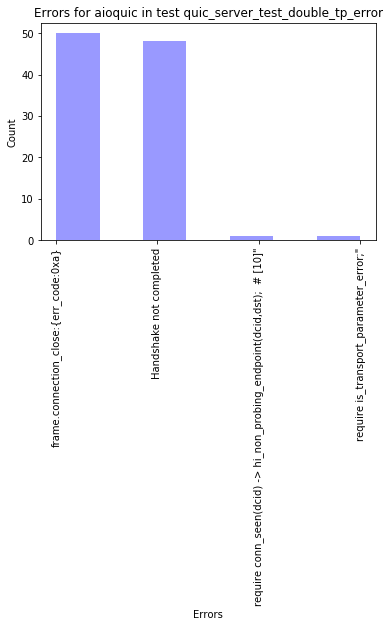

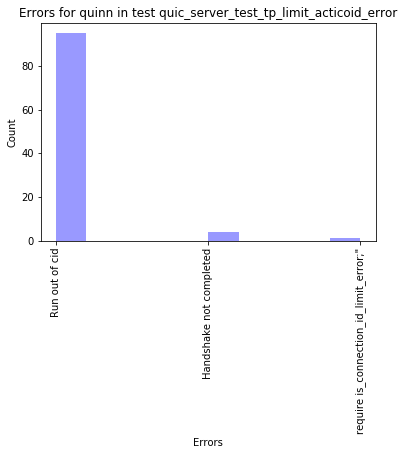

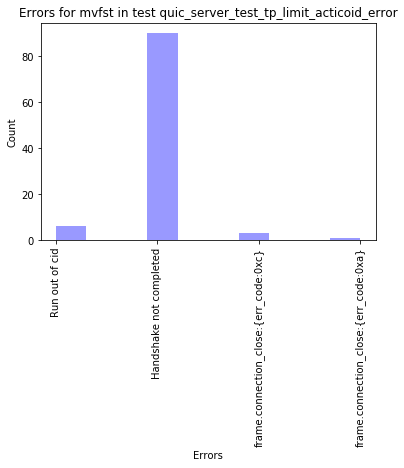

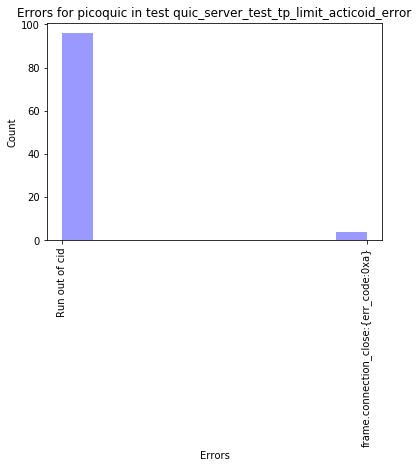

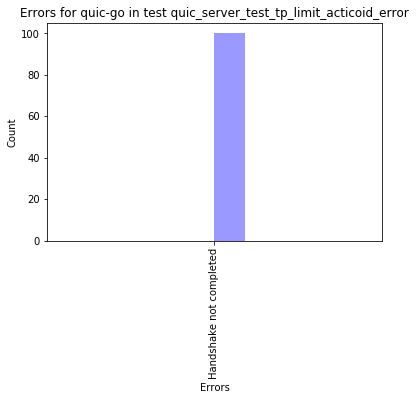

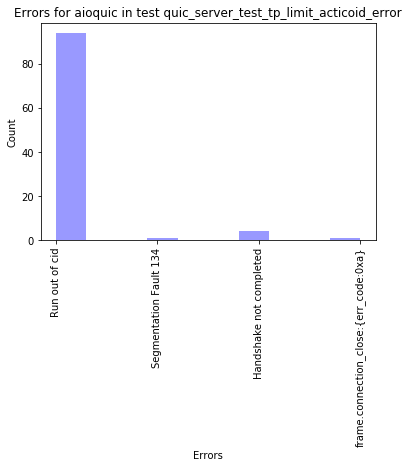

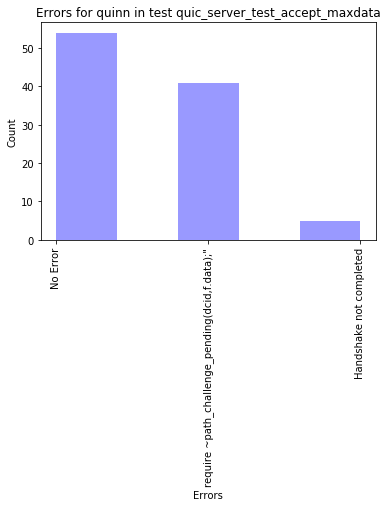

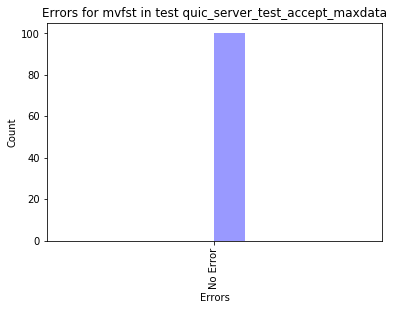

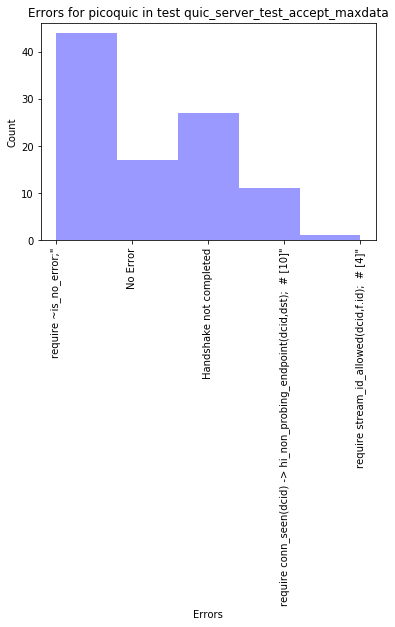

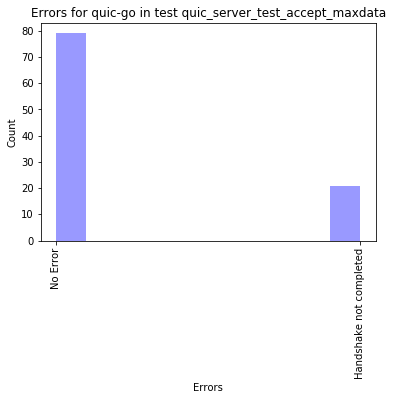

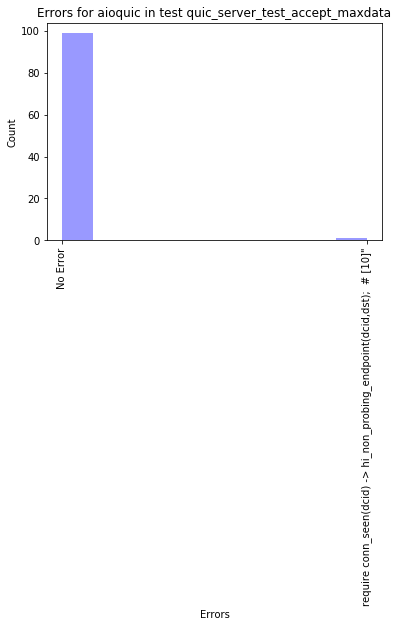

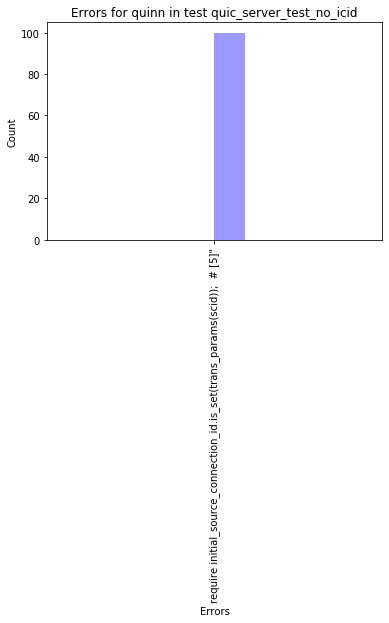

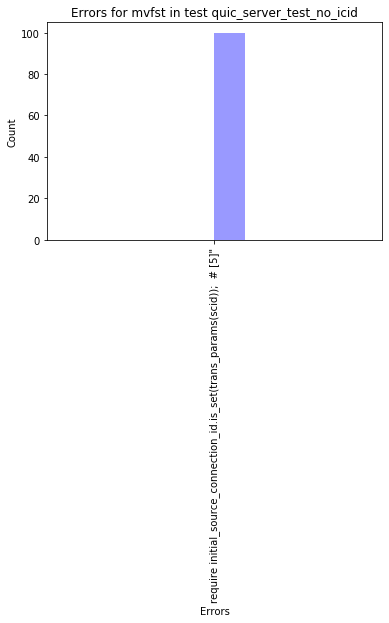

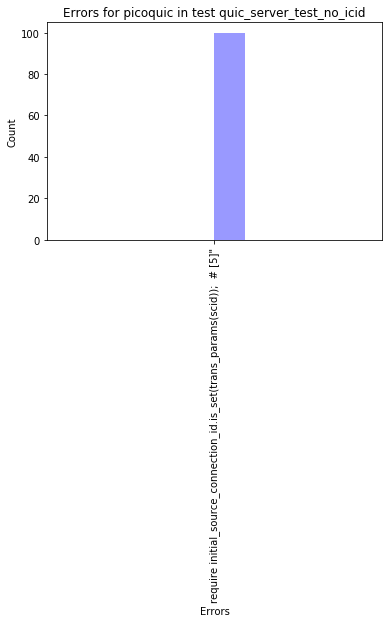

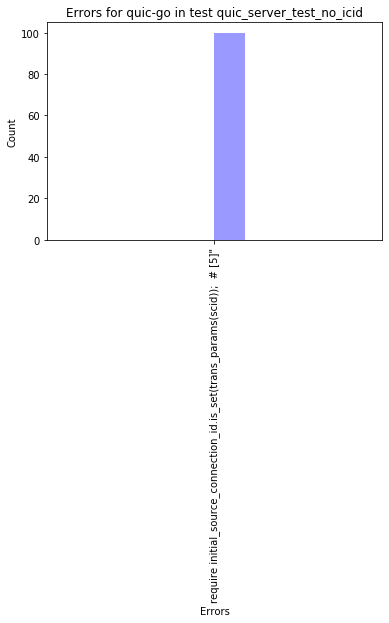

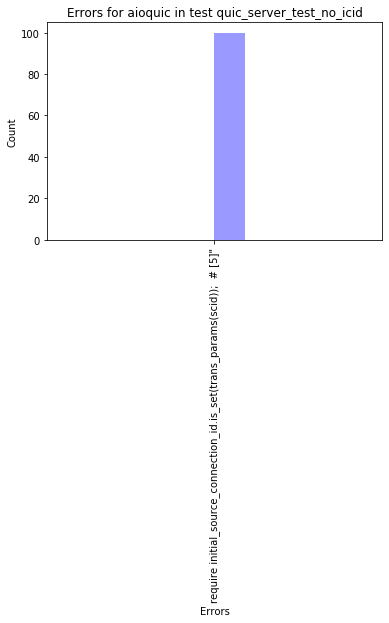

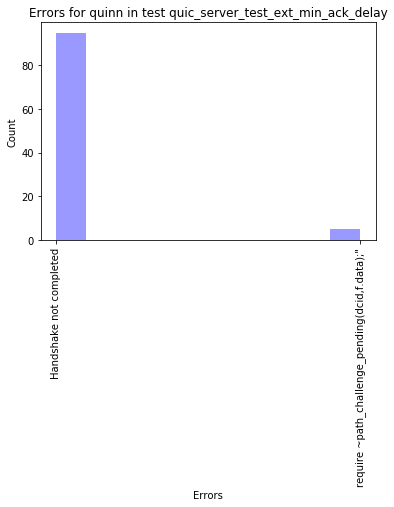

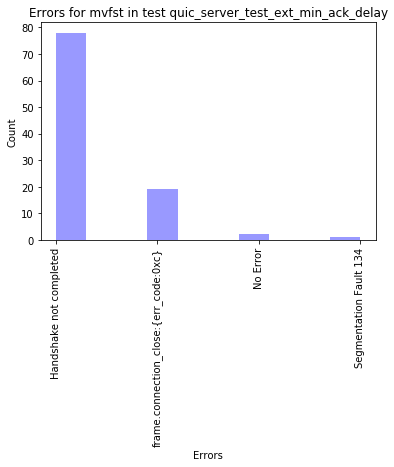

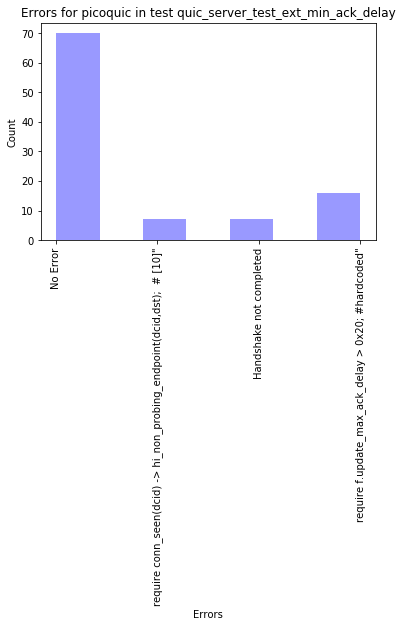

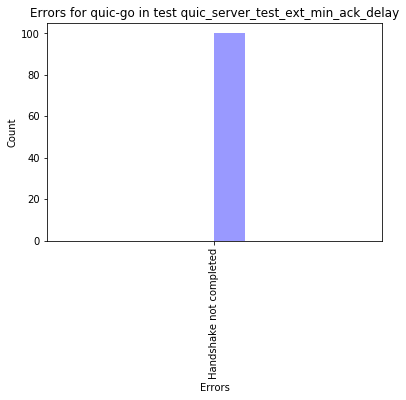

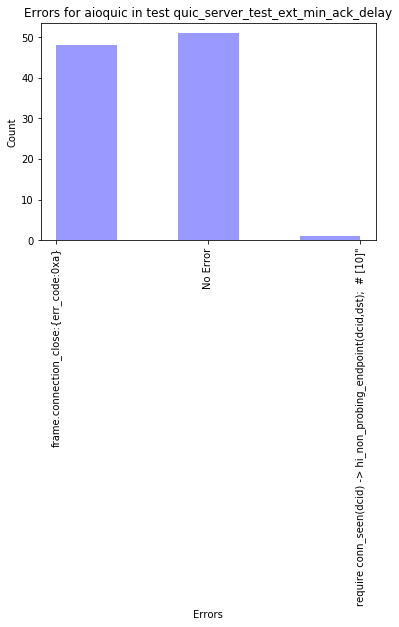

In [170]:
tests = ['quic_server_test_stream', 'quic_server_test_unkown',
       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
       'quic_server_test_token_error', 'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream',
       'quic_server_test_retirecoid_error',
       'quic_server_test_newcoid_zero_error',
       'quic_server_test_handshake_done_error',
       'quic_server_test_stop_sending',
       'quic_server_test_double_tp_error',
       'quic_server_test_tp_limit_acticoid_error',
       'quic_server_test_accept_maxdata', 'quic_server_test_no_icid',
       'quic_server_test_ext_min_ack_delay']

# 'quant',
servers = ['quinn', 'mvfst', 'picoquic',  'quic-go', 'aioquic']
#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

all_errors = train_df["ErrorIEV"].unique().tolist()
res = []
for i, row in train_df.iterrows():
    ind = all_errors.index(row["ErrorIEV"])
    res.append(ind)
train_df["ErrorsCode"] = res


for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        errors = subsubdf["ErrorIEV"].unique()
        
        all_errors = subsubdf["ErrorIEV"].unique().tolist()
        res = []
        for i, row in subsubdf.iterrows():
            ind = all_errors.index(row["ErrorIEV"])
            res.append(ind)
        subsubdf["ErrorsCode"] = res
                
        # seaborn histogram
        sns.distplot(subsubdf['ErrorsCode'], hist=True, kde=False, 
                     color='blue',hue="species")
        # Add labels
        plt.title("Errors for " + s + " in test " + t)
        plt.xticks(np.arange(0,len(all_errors)), rotation=90)  #'vertical'
        positions = tuple(np.arange(0, len(all_errors)))
        labels =  tuple(errors.tolist())
        plt.xticks(positions, labels)
        plt.xlabel('Errors')
        plt.ylabel('Count')
        filename = 'plot/' + "errors_for_" + s + "_in_test_" + t + '.png'
        plt.savefig(filename)
        plt.show()